# QUESTION ANSWERING 

Question Answering (QA) is a key task in natural language processing (NLP) aimed at **building systems that can understand and answer questions based on a provided context or knowledge base.** This experiment focuses on extractive QA using the **SQuAD dataset**, where the objective is to identify and extract relevant spans of text from the given context.

The model used is **LLAMA-3.2 1B**, part of the LLAMA family, which is an auto-regressive language models that employ an optimized transformer architecture. The 1B variant was selected due to **hardware constraints**, as larger models require more memory than available in this setup.

The goal of this experiment is to evaluate the **impact of quantization on model accuracy\text generation (F1-score, EM)** across various bit configurations and to analyze **potential speed improvements** when compared to the baseline non-quantized model.

## Libraries and huggingface login

In [2]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import gc
import utils
import importlib
from collections import Counter
import re
import string
import random
import utils_QA
import os
from transformers import AutoTokenizer
from datasets import load_dataset
from gptqmodel import GPTQModel, QuantizeConfig

In [ ]:
from huggingface_hub import login
login()

## Quantization of model for all the bit configurations [2, 3, 4, 8]

**GPTQ** is a post-training quantization method designed for generative pre-trained transformers (GPT) and similar models, the key features are:


- **Operates after pretraining** (or fine-tuning, if applicable).
- **Quantizes weights to 3-4 bits with negligible accuracy loss** (for this experiment 2 and 8 bits were also tested).
- **Efficiently quantize Large Models in few hours**.
- **Enables running massive models on fewer GPUs**.


In [36]:
dataset = utils_QA.load_squad_data()

Loading SQuAD dataset...


In [38]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


In [39]:
importlib.reload(utils)
model_id = "meta-llama/Llama-3.2-1B-Instruct"
squad_dataset = utils_QA.load_squad_data()['train']
tokenizer = AutoTokenizer.from_pretrained(model_id)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
preprocessed_dataset = utils_QA.preprocess_squad_for_quantization(squad_dataset, tokenizer)

Loading SQuAD dataset...


In [40]:
print(len(preprocessed_dataset))
used_dataset = preprocessed_dataset[:500]

87599


In [6]:
utils.quantize_for_all_bits_precision("SQuAD_models",used_dataset, model_id, "SQuAD")

INFO - Auto pick kernel based on compatibility: <class 'gptqmodel.nn_modules.qlinear.dynamic_cuda.DynamicCudaQuantLinear'>
WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 224.044.
WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


QUANTIZING WITH 2 bits and group size of 128 
  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '5.56343', 'damp': '0.01000', 'time': '1.335'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.14392', 'damp': '0.01000', 'time': '0.864'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '11.66676', 'damp': '0.01000', 'time': '0.908'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.01557', 'damp': '0.01000', 'time': '0.805'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '10.49259', 'damp': '0.01000', 'time': '0.949'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '13.25018', 'damp': '0.01000', 'time': '0.923'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.08480', 'damp': '0.01000', 'time': '4.368'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:03:07 / 0:24:56 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '11.48079', 'damp': '0.01000', 'time': '1.313'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.64036', 'damp': '0.01000', 'time': '1.348'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '21.62207', 'damp': '0.01000', 'time': '1.355'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.03625', 'damp': '0.01000', 'time': '0.822'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '17.52326', 'damp': '0.01000', 'time': '0.921'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '24.08031', 'damp': '0.01000', 'time': '1.048'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '153.29413', 'damp': '0.01000', 'time': '4.138'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:06:15 / 0:33:20 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '16.63268', 'damp': '0.01000', 'time': '0.930'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '1.18662', 'damp': '0.01000', 'time': '0.920'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '33.29968', 'damp': '0.01000', 'time': '1.171'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.03752', 'damp': '0.01000', 'time': '0.966'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '19.42162', 'damp': '0.01000', 'time': '0.921'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '31.16689', 'damp': '0.01000', 'time': '0.984'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.21522', 'damp': '0.01000', 'time': '4.169'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:09:15 / 0:37:00 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '13.97844', 'damp': '0.01000', 'time': '1.001'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '1.82527', 'damp': '0.01000', 'time': '0.998'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '30.67407', 'damp': '0.01000', 'time': '1.001'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.06532', 'damp': '0.01000', 'time': '0.919'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '26.17309', 'damp': '0.01000', 'time': '0.959'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '52.07448', 'damp': '0.01000', 'time': '1.073'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.33294', 'damp': '0.01000', 'time': '4.649'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:12:14 / 0:39:08 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '16.69926', 'damp': '0.01000', 'time': '1.042'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '1.96815', 'damp': '0.01000', 'time': '1.000'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '34.86136', 'damp': '0.01000', 'time': '1.046'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.11322', 'damp': '0.01000', 'time': '0.864'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '29.60918', 'damp': '0.01000', 'time': '0.892'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '63.69839', 'damp': '0.01000', 'time': '0.904'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.41660', 'damp': '0.01000', 'time': '4.008'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:15:21 / 0:40:56 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '25.22151', 'damp': '0.01000', 'time': '0.989'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '1.81841', 'damp': '0.01000', 'time': '1.015'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '45.96384', 'damp': '0.01000', 'time': '1.036'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.12916', 'damp': '0.01000', 'time': '0.927'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '32.71553', 'damp': '0.01000', 'time': '0.875'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '60.22275', 'damp': '0.01000', 'time': '0.915'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.48469', 'damp': '0.01000', 'time': '3.991'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:18:18 / 0:41:49 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '23.71175', 'damp': '0.01000', 'time': '1.034'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '2.49897', 'damp': '0.01000', 'time': '0.967'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '37.24316', 'damp': '0.01000', 'time': '1.179'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.20552', 'damp': '0.01000', 'time': '1.001'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '33.74998', 'damp': '0.01000', 'time': '0.972'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '60.73391', 'damp': '0.01000', 'time': '0.942'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.53041', 'damp': '0.01000', 'time': '4.086'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:21:14 / 0:42:28 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '24.84320', 'damp': '0.01000', 'time': '0.872'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '3.00641', 'damp': '0.01000', 'time': '0.855'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '46.36061', 'damp': '0.01000', 'time': '0.930'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.21829', 'damp': '0.01000', 'time': '0.959'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '36.89478', 'damp': '0.01000', 'time': '0.940'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '59.60882', 'damp': '0.01000', 'time': '1.033'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.61877', 'damp': '0.01000', 'time': '3.956'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:24:04 / 0:42:47 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '29.91346', 'damp': '0.01000', 'time': '0.805'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '3.02093', 'damp': '0.01000', 'time': '0.955'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '49.07095', 'damp': '0.01000', 'time': '1.106'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.26361', 'damp': '0.01000', 'time': '0.806'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '41.59424', 'damp': '0.01000', 'time': '0.965'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '65.16736', 'damp': '0.01000', 'time': '1.032'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.78892', 'damp': '0.01000', 'time': '3.554'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:27:06 / 0:43:21 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '24.67468', 'damp': '0.01000', 'time': '0.955'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '3.58946', 'damp': '0.01000', 'time': '0.902'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '59.62485', 'damp': '0.01000', 'time': '1.014'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.44853', 'damp': '0.01000', 'time': '0.919'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '46.09818', 'damp': '0.01000', 'time': '0.890'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '74.81784', 'damp': '0.01000', 'time': '1.059'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.96042', 'damp': '0.01000', 'time': '3.939'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:30:16 / 0:44:01 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '29.49023', 'damp': '0.01000', 'time': '0.992'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '3.62825', 'damp': '0.01000', 'time': '1.102'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '61.42006', 'damp': '0.01000', 'time': '1.064'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.38995', 'damp': '0.01000', 'time': '0.794'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '56.66953', 'damp': '0.01000', 'time': '0.851'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '89.02526', 'damp': '0.01000', 'time': '0.895'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '1.34765', 'damp': '0.01000', 'time': '3.966'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:33:28 / 0:44:37 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '36.00480', 'damp': '0.01000', 'time': '0.919'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '3.87648', 'damp': '0.01000', 'time': '1.100'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '61.76474', 'damp': '0.01000', 'time': '1.100'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.28388', 'damp': '0.01000', 'time': '0.968'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '67.11605', 'damp': '0.01000', 'time': '1.050'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '102.99495', 'damp': '0.01000', 'time': '1.167'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '1.74378', 'damp': '0.01000', 'time': '5.469'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:36:26 / 0:44:50 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '35.28570', 'damp': '0.01000', 'time': '1.164'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '4.07706', 'damp': '0.01000', 'time': '1.228'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '63.98922', 'damp': '0.01000', 'time': '1.299'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.30403', 'damp': '0.01000', 'time': '1.119'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '74.93631', 'damp': '0.01000', 'time': '0.988'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '108.83497', 'damp': '0.01000', 'time': '1.076'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '2.32780', 'damp': '0.01000', 'time': '4.334'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:39:25 / 0:45:02 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '35.91396', 'damp': '0.01000', 'time': '0.948'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '6.67391', 'damp': '0.01000', 'time': '1.033'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '71.81364', 'damp': '0.01000', 'time': '1.115'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.50011', 'damp': '0.01000', 'time': '0.874'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '88.78588', 'damp': '0.01000', 'time': '0.907'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '117.84733', 'damp': '0.01000', 'time': '0.928'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '3.45801', 'damp': '0.01000', 'time': '4.382'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:42:23 / 0:45:12 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '34.08298', 'damp': '0.01000', 'time': '0.845'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '13.02924', 'damp': '0.01000', 'time': '0.949'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '70.02423', 'damp': '0.01000', 'time': '1.018'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '1.26981', 'damp': '0.01000', 'time': '0.890'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '99.59666', 'damp': '0.01000', 'time': '0.933'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '143.10878', 'damp': '0.01000', 'time': '0.889'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '4.33703', 'damp': '0.01000', 'time': '4.226'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:45:27 / 0:45:27 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '32.11711', 'damp': '0.01000', 'time': '0.792'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '14.07846', 'damp': '0.01000', 'time': '0.808'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '65.62634', 'damp': '0.01000', 'time': '0.936'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '3.40117', 'damp': '0.01000', 'time': '0.942'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '125.56319', 'damp': '0.01000', 'time': '0.868'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '166.57038', 'damp': '0.01000', 'time': '0.939'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '10.06722', 'damp': '0.01000', 'time': '3.678'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '5.56343', 'damp': '0.01000', 'time': '1.335'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.14392', 'damp': '0.01000', 'time': '0.864'}, {'layer': 0, 'module': 'self_attn

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%7 / 2:05:04 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING MODEL


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1251.74MB, 1.22GB
INFO - Size difference: 3462.58MB, 3.38GB - 73.45%
WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 224.044.
WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


QUANTIZING WITH 3 bits and group size of 128 
  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.71566', 'damp': '0.01000', 'time': '1.267'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.02125', 'damp': '0.01000', 'time': '1.370'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '1.51067', 'damp': '0.01000', 'time': '1.391'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.00237', 'damp': '0.01000', 'time': '1.101'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '1.56522', 'damp': '0.01000', 'time': '1.053'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '1.95740', 'damp': '0.01000', 'time': '1.096'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.00927', 'damp': '0.01000', 'time': '5.403'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:03:27 / 0:27:36 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '1.46730', 'damp': '0.01000', 'time': '1.140'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.08739', 'damp': '0.01000', 'time': '0.895'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '2.92839', 'damp': '0.01000', 'time': '1.056'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.00502', 'damp': '0.01000', 'time': '1.009'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '2.48426', 'damp': '0.01000', 'time': '1.011'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '3.39654', 'damp': '0.01000', 'time': '1.099'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '29.27916', 'damp': '0.01000', 'time': '4.230'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:06:39 / 0:35:28 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '2.73800', 'damp': '0.01000', 'time': '0.893'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.19887', 'damp': '0.01000', 'time': '0.934'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '5.36225', 'damp': '0.01000', 'time': '1.019'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.00588', 'damp': '0.01000', 'time': '0.963'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '3.08433', 'damp': '0.01000', 'time': '0.972'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '4.88547', 'damp': '0.01000', 'time': '1.035'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.02572', 'damp': '0.01000', 'time': '3.997'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:09:43 / 0:38:52 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '2.00573', 'damp': '0.01000', 'time': '0.853'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '0.27586', 'damp': '0.01000', 'time': '1.001'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '4.42396', 'damp': '0.01000', 'time': '1.061'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.01017', 'damp': '0.01000', 'time': '0.858'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '3.89317', 'damp': '0.01000', 'time': '0.865'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '7.69693', 'damp': '0.01000', 'time': '0.946'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.03988', 'damp': '0.01000', 'time': '3.822'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:12:48 / 0:40:57 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '2.15002', 'damp': '0.01000', 'time': '0.967'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '0.26188', 'damp': '0.01000', 'time': '1.229'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '4.46985', 'damp': '0.01000', 'time': '1.412'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.01939', 'damp': '0.01000', 'time': '1.114'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '3.96191', 'damp': '0.01000', 'time': '1.162'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '8.47804', 'damp': '0.01000', 'time': '1.360'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.05029', 'damp': '0.01000', 'time': '3.732'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:15:47 / 0:42:05 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '3.19670', 'damp': '0.01000', 'time': '0.952'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '0.23093', 'damp': '0.01000', 'time': '1.028'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '5.71360', 'damp': '0.01000', 'time': '1.061'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.02262', 'damp': '0.01000', 'time': '1.001'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '4.24175', 'damp': '0.01000', 'time': '0.878'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '7.75326', 'damp': '0.01000', 'time': '1.110'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.06108', 'damp': '0.01000', 'time': '3.792'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:18:46 / 0:42:53 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '2.69975', 'damp': '0.01000', 'time': '1.040'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '0.30200', 'damp': '0.01000', 'time': '0.849'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '4.31446', 'damp': '0.01000', 'time': '1.217'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.03525', 'damp': '0.01000', 'time': '0.921'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '4.29479', 'damp': '0.01000', 'time': '0.906'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '7.66166', 'damp': '0.01000', 'time': '1.021'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.06514', 'damp': '0.01000', 'time': '5.019'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:21:46 / 0:43:32 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '2.67373', 'damp': '0.01000', 'time': '0.895'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '0.34284', 'damp': '0.01000', 'time': '0.974'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '5.05263', 'damp': '0.01000', 'time': '1.120'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.03451', 'damp': '0.01000', 'time': '0.823'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '4.40471', 'damp': '0.01000', 'time': '0.854'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '7.07976', 'damp': '0.01000', 'time': '0.881'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.07248', 'damp': '0.01000', 'time': '3.799'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:24:58 / 0:44:23 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '3.12872', 'damp': '0.01000', 'time': '0.821'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '0.32564', 'damp': '0.01000', 'time': '0.878'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '5.20207', 'damp': '0.01000', 'time': '1.028'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.04509', 'damp': '0.01000', 'time': '0.855'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '4.82335', 'damp': '0.01000', 'time': '0.914'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '7.52982', 'damp': '0.01000', 'time': '0.874'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.09486', 'damp': '0.01000', 'time': '3.753'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:27:54 / 0:44:38 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '2.49449', 'damp': '0.01000', 'time': '0.836'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '0.38145', 'damp': '0.01000', 'time': '0.903'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '6.12381', 'damp': '0.01000', 'time': '1.069'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.06198', 'damp': '0.01000', 'time': '1.075'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '4.99544', 'damp': '0.01000', 'time': '1.102'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '8.08283', 'damp': '0.01000', 'time': '1.227'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.11023', 'damp': '0.01000', 'time': '3.865'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:30:49 / 0:44:49 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '2.85796', 'damp': '0.01000', 'time': '1.165'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '0.38738', 'damp': '0.01000', 'time': '1.008'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '6.01930', 'damp': '0.01000', 'time': '1.134'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.04108', 'damp': '0.01000', 'time': '0.993'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '5.78859', 'damp': '0.01000', 'time': '0.995'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '9.02770', 'damp': '0.01000', 'time': '1.010'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.13510', 'damp': '0.01000', 'time': '4.047'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:33:52 / 0:45:09 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '3.39095', 'damp': '0.01000', 'time': '1.177'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '0.40026', 'damp': '0.01000', 'time': '1.393'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '5.94783', 'damp': '0.01000', 'time': '1.347'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.03255', 'damp': '0.01000', 'time': '1.133'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '6.53779', 'damp': '0.01000', 'time': '0.996'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '10.00984', 'damp': '0.01000', 'time': '1.040'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '0.15267', 'damp': '0.01000', 'time': '5.408'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:36:58 / 0:45:29 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '3.34969', 'damp': '0.01000', 'time': '0.842'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '0.41149', 'damp': '0.01000', 'time': '0.907'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '5.92100', 'damp': '0.01000', 'time': '1.089'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.03060', 'damp': '0.01000', 'time': '0.864'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '6.90508', 'damp': '0.01000', 'time': '0.880'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '10.02917', 'damp': '0.01000', 'time': '0.919'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '0.17705', 'damp': '0.01000', 'time': '3.844'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:39:54 / 0:45:36 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '3.32598', 'damp': '0.01000', 'time': '0.903'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '0.67271', 'damp': '0.01000', 'time': '0.934'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '6.74448', 'damp': '0.01000', 'time': '1.113'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.03621', 'damp': '0.01000', 'time': '0.925'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '8.16002', 'damp': '0.01000', 'time': '1.008'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '10.83677', 'damp': '0.01000', 'time': '1.129'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '0.25521', 'damp': '0.01000', 'time': '4.217'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:42:58 / 0:45:49 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '3.60856', 'damp': '0.01000', 'time': '0.862'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '1.39612', 'damp': '0.01000', 'time': '0.930'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '6.96410', 'damp': '0.01000', 'time': '1.038'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '0.09244', 'damp': '0.01000', 'time': '0.846'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '9.33870', 'damp': '0.01000', 'time': '0.991'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '13.39192', 'damp': '0.01000', 'time': '1.049'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '0.34054', 'damp': '0.01000', 'time': '3.774'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:45:55 / 0:45:55 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '3.42521', 'damp': '0.01000', 'time': '1.008'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '1.45071', 'damp': '0.01000', 'time': '1.087'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '6.46436', 'damp': '0.01000', 'time': '1.020'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '0.50613', 'damp': '0.01000', 'time': '1.045'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '11.71253', 'damp': '0.01000', 'time': '0.995'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '15.47111', 'damp': '0.01000', 'time': '1.046'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '0.94651', 'damp': '0.01000', 'time': '3.889'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.71566', 'damp': '0.01000', 'time': '1.267'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.02125', 'damp': '0.01000', 'time': '1.370'}, {'layer': 0, 'module': 'self_attn.q_pro

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%4 / 2:18:08 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING MODEL


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1368.65MB, 1.34GB
INFO - Size difference: 3345.67MB, 3.27GB - 70.97%
WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 224.044.
WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


QUANTIZING WITH 4 bits and group size of 128 
  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.14486', 'damp': '0.01000', 'time': '1.075'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00446', 'damp': '0.01000', 'time': '0.971'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '0.30719', 'damp': '0.01000', 'time': '1.022'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.00049', 'damp': '0.01000', 'time': '1.011'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '0.32752', 'damp': '0.01000', 'time': '0.932'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '0.40887', 'damp': '0.01000', 'time': '1.071'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.00189', 'damp': '0.01000', 'time': '5.418'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:03:04 / 0:24:32 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '0.29654', 'damp': '0.01000', 'time': '0.890'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.01789', 'damp': '0.01000', 'time': '0.943'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '0.59294', 'damp': '0.01000', 'time': '1.076'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.00107', 'damp': '0.01000', 'time': '1.011'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '0.51976', 'damp': '0.01000', 'time': '0.888'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '0.70983', 'damp': '0.01000', 'time': '1.002'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '4.01897', 'damp': '0.01000', 'time': '4.013'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:06:07 / 0:32:37 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '0.61177', 'damp': '0.01000', 'time': '0.997'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.04501', 'damp': '0.01000', 'time': '1.055'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '1.19161', 'damp': '0.01000', 'time': '1.203'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.00115', 'damp': '0.01000', 'time': '0.955'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '0.69700', 'damp': '0.01000', 'time': '0.871'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '1.09958', 'damp': '0.01000', 'time': '1.134'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.00563', 'damp': '0.01000', 'time': '4.583'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:09:07 / 0:36:28 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '0.42607', 'damp': '0.01000', 'time': '1.050'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '0.05978', 'damp': '0.01000', 'time': '0.983'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '0.94035', 'damp': '0.01000', 'time': '0.935'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.00252', 'damp': '0.01000', 'time': '0.998'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '0.83639', 'damp': '0.01000', 'time': '1.016'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '1.64731', 'damp': '0.01000', 'time': '1.018'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.00880', 'damp': '0.01000', 'time': '4.310'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:12:04 / 0:38:36 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '0.43397', 'damp': '0.01000', 'time': '0.856'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '0.05424', 'damp': '0.01000', 'time': '1.044'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '0.90581', 'damp': '0.01000', 'time': '1.065'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.00451', 'damp': '0.01000', 'time': '0.970'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '0.82343', 'damp': '0.01000', 'time': '0.952'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '1.75802', 'damp': '0.01000', 'time': '1.044'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.01044', 'damp': '0.01000', 'time': '4.030'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:14:59 / 0:39:57 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '0.64054', 'damp': '0.01000', 'time': '0.845'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '0.04575', 'damp': '0.01000', 'time': '1.006'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '1.12892', 'damp': '0.01000', 'time': '1.094'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.00478', 'damp': '0.01000', 'time': '0.868'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '0.85333', 'damp': '0.01000', 'time': '0.874'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '1.55557', 'damp': '0.01000', 'time': '1.056'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.01214', 'damp': '0.01000', 'time': '4.019'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:17:52 / 0:40:50 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '0.51701', 'damp': '0.01000', 'time': '1.003'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '0.05880', 'damp': '0.01000', 'time': '1.089'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '0.83470', 'damp': '0.01000', 'time': '1.382'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.00719', 'damp': '0.01000', 'time': '1.148'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '0.85252', 'damp': '0.01000', 'time': '1.004'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '1.51811', 'damp': '0.01000', 'time': '0.916'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.01263', 'damp': '0.01000', 'time': '4.234'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:20:48 / 0:41:36 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '0.50733', 'damp': '0.01000', 'time': '0.975'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '0.06609', 'damp': '0.01000', 'time': '0.913'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '0.97175', 'damp': '0.01000', 'time': '0.970'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.00683', 'damp': '0.01000', 'time': '0.848'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '0.86665', 'damp': '0.01000', 'time': '0.887'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '1.39189', 'damp': '0.01000', 'time': '0.927'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.01393', 'damp': '0.01000', 'time': '3.713'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:23:42 / 0:42:08 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '0.59931', 'damp': '0.01000', 'time': '0.883'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '0.06286', 'damp': '0.01000', 'time': '1.015'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '1.00185', 'damp': '0.01000', 'time': '1.123'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.00878', 'damp': '0.01000', 'time': '0.978'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '0.94447', 'damp': '0.01000', 'time': '1.051'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '1.47314', 'damp': '0.01000', 'time': '1.303'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.01812', 'damp': '0.01000', 'time': '4.084'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:26:37 / 0:42:35 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '0.47614', 'damp': '0.01000', 'time': '0.895'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '0.07396', 'damp': '0.01000', 'time': '0.977'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '1.17880', 'damp': '0.01000', 'time': '0.952'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.01188', 'damp': '0.01000', 'time': '0.822'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '0.97950', 'damp': '0.01000', 'time': '0.884'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '1.57752', 'damp': '0.01000', 'time': '1.017'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.02103', 'damp': '0.01000', 'time': '3.588'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:29:31 / 0:42:56 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '0.54730', 'damp': '0.01000', 'time': '0.922'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '0.07803', 'damp': '0.01000', 'time': '0.937'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '1.16967', 'damp': '0.01000', 'time': '0.997'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.00771', 'damp': '0.01000', 'time': '0.822'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '1.14168', 'damp': '0.01000', 'time': '0.862'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '1.77743', 'damp': '0.01000', 'time': '0.907'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.02602', 'damp': '0.01000', 'time': '3.983'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:32:23 / 0:43:10 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '0.65973', 'damp': '0.01000', 'time': '0.859'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '0.08216', 'damp': '0.01000', 'time': '0.999'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '1.17471', 'damp': '0.01000', 'time': '1.102'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.00672', 'damp': '0.01000', 'time': '0.875'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '1.31091', 'damp': '0.01000', 'time': '0.865'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '2.00288', 'damp': '0.01000', 'time': '0.856'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '0.02937', 'damp': '0.01000', 'time': '3.639'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:35:16 / 0:43:24 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '0.66549', 'damp': '0.01000', 'time': '0.933'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '0.08431', 'damp': '0.01000', 'time': '0.858'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '1.18061', 'damp': '0.01000', 'time': '1.001'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.00588', 'damp': '0.01000', 'time': '0.834'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '1.41615', 'damp': '0.01000', 'time': '0.850'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '2.05547', 'damp': '0.01000', 'time': '0.974'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '0.03501', 'damp': '0.01000', 'time': '4.027'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:38:11 / 0:43:38 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '0.68022', 'damp': '0.01000', 'time': '0.845'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '0.14597', 'damp': '0.01000', 'time': '0.977'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '1.38140', 'damp': '0.01000', 'time': '1.087'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.00682', 'damp': '0.01000', 'time': '0.862'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '1.69925', 'damp': '0.01000', 'time': '0.882'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '2.25505', 'damp': '0.01000', 'time': '1.002'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '0.05089', 'damp': '0.01000', 'time': '3.837'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:41:02 / 0:43:46 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '0.75426', 'damp': '0.01000', 'time': '0.909'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '0.31074', 'damp': '0.01000', 'time': '0.900'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '1.44848', 'damp': '0.01000', 'time': '0.968'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '0.01596', 'damp': '0.01000', 'time': '0.903'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '1.96239', 'damp': '0.01000', 'time': '0.906'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '2.81626', 'damp': '0.01000', 'time': '0.970'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '0.06905', 'damp': '0.01000', 'time': '4.020'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:43:56 / 0:43:56 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '0.73209', 'damp': '0.01000', 'time': '0.903'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '0.31425', 'damp': '0.01000', 'time': '0.956'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '1.33773', 'damp': '0.01000', 'time': '1.173'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '0.09836', 'damp': '0.01000', 'time': '1.182'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '2.46332', 'damp': '0.01000', 'time': '0.849'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '3.26585', 'damp': '0.01000', 'time': '0.879'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '0.20260', 'damp': '0.01000', 'time': '3.547'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.14486', 'damp': '0.01000', 'time': '1.075'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00446', 'damp': '0.01000', 'time': '0.971'}, {'layer': 0, 'module': 'self_attn.q_proj'

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%1 / 2:12:32 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING MODEL


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1485.55MB, 1.45GB
INFO - Size difference: 3228.77MB, 3.15GB - 68.49%
WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 224.044.
WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


QUANTIZING WITH 8 bits and group size of 128 
  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.00049', 'damp': '0.01000', 'time': '0.897'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.978'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '0.00104', 'damp': '0.01000', 'time': '0.966'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.00000', 'damp': '0.01000', 'time': '0.819'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '0.00112', 'damp': '0.01000', 'time': '0.840'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '0.00140', 'damp': '0.01000', 'time': '0.923'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.00001', 'damp': '0.01000', 'time': '3.720'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:03:14 / 0:25:52 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '0.00100', 'damp': '0.01000', 'time': '0.850'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.00006', 'damp': '0.01000', 'time': '0.976'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '0.00201', 'damp': '0.01000', 'time': '0.984'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.00000', 'damp': '0.01000', 'time': '0.904'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '0.00177', 'damp': '0.01000', 'time': '0.847'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '0.00242', 'damp': '0.01000', 'time': '0.977'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '0.00250', 'damp': '0.01000', 'time': '4.012'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:06:11 / 0:32:58 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '0.00210', 'damp': '0.01000', 'time': '0.899'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.00016', 'damp': '0.01000', 'time': '0.882'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '0.00411', 'damp': '0.01000', 'time': '1.010'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.00000', 'damp': '0.01000', 'time': '0.985'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '0.00239', 'damp': '0.01000', 'time': '0.994'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '0.00376', 'damp': '0.01000', 'time': '0.957'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '4.205'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:09:12 / 0:36:48 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '0.00142', 'damp': '0.01000', 'time': '0.861'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '0.00020', 'damp': '0.01000', 'time': '0.885'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '0.00316', 'damp': '0.01000', 'time': '1.135'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.00001', 'damp': '0.01000', 'time': '0.906'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '0.00282', 'damp': '0.01000', 'time': '0.927'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '0.00556', 'damp': '0.01000', 'time': '0.986'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.00003', 'damp': '0.01000', 'time': '3.917'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:12:19 / 0:39:24 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '0.00144', 'damp': '0.01000', 'time': '0.926'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '0.00018', 'damp': '0.01000', 'time': '0.899'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '0.00302', 'damp': '0.01000', 'time': '0.977'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.946'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '0.00277', 'damp': '0.01000', 'time': '0.989'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '0.00591', 'damp': '0.01000', 'time': '0.994'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.00003', 'damp': '0.01000', 'time': '3.989'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:15:31 / 0:41:22 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '0.00214', 'damp': '0.01000', 'time': '0.858'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '0.00015', 'damp': '0.01000', 'time': '0.926'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '0.00372', 'damp': '0.01000', 'time': '0.978'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.833'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '0.00287', 'damp': '0.01000', 'time': '0.994'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '0.00523', 'damp': '0.01000', 'time': '0.972'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.00004', 'damp': '0.01000', 'time': '4.214'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:18:33 / 0:42:24 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '0.00171', 'damp': '0.01000', 'time': '0.931'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '0.00020', 'damp': '0.01000', 'time': '0.953'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '0.00279', 'damp': '0.01000', 'time': '0.975'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.929'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '0.00287', 'damp': '0.01000', 'time': '0.925'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '0.00511', 'damp': '0.01000', 'time': '0.976'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.00004', 'damp': '0.01000', 'time': '4.085'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:21:32 / 0:43:04 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '0.00169', 'damp': '0.01000', 'time': '0.877'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '0.00022', 'damp': '0.01000', 'time': '0.933'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '0.00324', 'damp': '0.01000', 'time': '0.967'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.857'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '0.00291', 'damp': '0.01000', 'time': '0.911'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '0.00469', 'damp': '0.01000', 'time': '0.908'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.00005', 'damp': '0.01000', 'time': '3.879'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:24:30 / 0:43:33 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '0.00199', 'damp': '0.01000', 'time': '0.927'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '0.00021', 'damp': '0.01000', 'time': '1.006'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '0.00335', 'damp': '0.01000', 'time': '1.153'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.00003', 'damp': '0.01000', 'time': '1.127'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '0.00318', 'damp': '0.01000', 'time': '1.286'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '0.00494', 'damp': '0.01000', 'time': '1.146'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.00006', 'damp': '0.01000', 'time': '5.230'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:27:28 / 0:43:56 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '0.00159', 'damp': '0.01000', 'time': '0.919'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '0.00025', 'damp': '0.01000', 'time': '0.916'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '0.00396', 'damp': '0.01000', 'time': '1.095'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.00004', 'damp': '0.01000', 'time': '1.007'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '0.00330', 'damp': '0.01000', 'time': '0.873'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '0.00530', 'damp': '0.01000', 'time': '1.077'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.00007', 'damp': '0.01000', 'time': '3.709'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:30:21 / 0:44:08 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '0.00184', 'damp': '0.01000', 'time': '1.136'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '0.00027', 'damp': '0.01000', 'time': '1.260'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '0.00394', 'damp': '0.01000', 'time': '0.978'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.00003', 'damp': '0.01000', 'time': '0.841'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '0.00386', 'damp': '0.01000', 'time': '0.877'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '0.00599', 'damp': '0.01000', 'time': '0.936'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.00009', 'damp': '0.01000', 'time': '3.726'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:33:15 / 0:44:20 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '0.00222', 'damp': '0.01000', 'time': '0.827'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '0.00028', 'damp': '0.01000', 'time': '1.074'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '0.00396', 'damp': '0.01000', 'time': '1.058'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.990'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '0.00444', 'damp': '0.01000', 'time': '0.889'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '0.00678', 'damp': '0.01000', 'time': '0.927'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '0.00010', 'damp': '0.01000', 'time': '3.747'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:36:11 / 0:44:32 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '0.00226', 'damp': '0.01000', 'time': '0.832'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '0.00029', 'damp': '0.01000', 'time': '0.845'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '0.00398', 'damp': '0.01000', 'time': '0.982'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.842'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '0.00482', 'damp': '0.01000', 'time': '0.912'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '0.00699', 'damp': '0.01000', 'time': '1.045'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '0.00012', 'damp': '0.01000', 'time': '4.128'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:39:04 / 0:44:38 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '0.00230', 'damp': '0.01000', 'time': '0.840'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '0.00051', 'damp': '0.01000', 'time': '1.019'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '0.00468', 'damp': '0.01000', 'time': '1.441'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.846'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '0.00579', 'damp': '0.01000', 'time': '1.011'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '0.00768', 'damp': '0.01000', 'time': '1.033'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '0.00017', 'damp': '0.01000', 'time': '4.500'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:42:01 / 0:44:49 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '0.00254', 'damp': '0.01000', 'time': '0.834'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '0.00113', 'damp': '0.01000', 'time': '0.887'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '0.00489', 'damp': '0.01000', 'time': '1.005'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '0.00005', 'damp': '0.01000', 'time': '0.896'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '0.00668', 'damp': '0.01000', 'time': '0.860'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '0.00958', 'damp': '0.01000', 'time': '1.013'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '0.00023', 'damp': '0.01000', 'time': '3.799'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:44:53 / 0:44:53 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '0.00249', 'damp': '0.01000', 'time': '0.906'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '0.00108', 'damp': '0.01000', 'time': '0.893'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '0.00454', 'damp': '0.01000', 'time': '1.068'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '0.00034', 'damp': '0.01000', 'time': '1.012'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '0.00833', 'damp': '0.01000', 'time': '1.211'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '0.01107', 'damp': '0.01000', 'time': '1.143'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '0.00071', 'damp': '0.01000', 'time': '4.246'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.00049', 'damp': '0.01000', 'time': '0.897'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '0.978'}, {'layer': 0, 'module': 'self_attn.q_proj'

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%0 / 2:10:40 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING MODEL


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1953.18MB, 1.91GB
INFO - Size difference: 2761.14MB, 2.70GB - 58.57%


### Test with group size 64

In [41]:
# let's see if by changing group size we get better results
utils.quantize_for_all_bits_precision("SQuAD_models",used_dataset, model_id, "SQuAD", group_size = 64)

WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 224.044.


QUANTIZING WITH 2 bits and group size of 64 


WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '4.54264', 'damp': '0.01000', 'time': '1.219'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.11573', 'damp': '0.01000', 'time': '1.217'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '9.42746', 'damp': '0.01000', 'time': '1.131'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.01197', 'damp': '0.01000', 'time': '1.128'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '8.73856', 'damp': '0.01000', 'time': '0.941'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '11.00285', 'damp': '0.01000', 'time': '1.085'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.06447', 'damp': '0.01000', 'time': '4.035'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:03:51 / 0:30:48 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '9.21389', 'damp': '0.01000', 'time': '1.033'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.50870', 'damp': '0.01000', 'time': '0.985'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '17.19023', 'damp': '0.01000', 'time': '1.118'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.02764', 'damp': '0.01000', 'time': '1.030'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '14.52909', 'damp': '0.01000', 'time': '0.998'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '19.91745', 'damp': '0.01000', 'time': '1.186'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '141.08511', 'damp': '0.01000', 'time': '5.576'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:07:42 / 0:41:04 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '12.82075', 'damp': '0.01000', 'time': '1.031'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.92934', 'damp': '0.01000', 'time': '1.002'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '25.88854', 'damp': '0.01000', 'time': '1.201'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.03181', 'damp': '0.01000', 'time': '1.060'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '15.19111', 'damp': '0.01000', 'time': '1.107'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '24.51519', 'damp': '0.01000', 'time': '1.081'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.15475', 'damp': '0.01000', 'time': '4.828'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:11:31 / 0:46:04 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '10.73298', 'damp': '0.01000', 'time': '0.877'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '1.40961', 'damp': '0.01000', 'time': '1.078'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '23.66970', 'damp': '0.01000', 'time': '1.181'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.05822', 'damp': '0.01000', 'time': '1.090'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '20.39053', 'damp': '0.01000', 'time': '1.041'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '40.77580', 'damp': '0.01000', 'time': '1.064'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.23919', 'damp': '0.01000', 'time': '5.093'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:15:29 / 0:49:32 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '12.84686', 'damp': '0.01000', 'time': '1.135'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '1.49970', 'damp': '0.01000', 'time': '1.007'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '26.78848', 'damp': '0.01000', 'time': '1.185'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.10192', 'damp': '0.01000', 'time': '1.016'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '22.66809', 'damp': '0.01000', 'time': '1.119'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '48.94992', 'damp': '0.01000', 'time': '1.467'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.30023', 'damp': '0.01000', 'time': '5.162'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:19:18 / 0:51:28 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '19.13832', 'damp': '0.01000', 'time': '1.024'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '1.39093', 'damp': '0.01000', 'time': '1.098'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '35.18507', 'damp': '0.01000', 'time': '1.121'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.10717', 'damp': '0.01000', 'time': '1.056'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '24.96061', 'damp': '0.01000', 'time': '1.045'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '46.11524', 'damp': '0.01000', 'time': '0.989'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.35322', 'damp': '0.01000', 'time': '4.189'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:23:22 / 0:53:24 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '18.17193', 'damp': '0.01000', 'time': '0.900'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '1.90375', 'damp': '0.01000', 'time': '1.014'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '28.48762', 'damp': '0.01000', 'time': '1.167'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.18037', 'damp': '0.01000', 'time': '0.962'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '25.77379', 'damp': '0.01000', 'time': '1.016'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '46.48367', 'damp': '0.01000', 'time': '0.981'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.38640', 'damp': '0.01000', 'time': '5.250'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:27:08 / 0:54:16 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '18.82402', 'damp': '0.01000', 'time': '0.940'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '2.27927', 'damp': '0.01000', 'time': '1.069'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '35.17266', 'damp': '0.01000', 'time': '1.032'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.19160', 'damp': '0.01000', 'time': '0.948'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '27.85804', 'damp': '0.01000', 'time': '0.877'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '45.10421', 'damp': '0.01000', 'time': '0.923'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.44224', 'damp': '0.01000', 'time': '4.128'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:30:57 / 0:55:01 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '22.25863', 'damp': '0.01000', 'time': '0.930'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '2.23688', 'damp': '0.01000', 'time': '1.036'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '36.47785', 'damp': '0.01000', 'time': '0.992'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.22174', 'damp': '0.01000', 'time': '0.899'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '31.09108', 'damp': '0.01000', 'time': '0.983'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '48.75037', 'damp': '0.01000', 'time': '1.114'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.57082', 'damp': '0.01000', 'time': '5.468'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:34:48 / 0:55:40 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '18.21736', 'damp': '0.01000', 'time': '0.960'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '2.58878', 'damp': '0.01000', 'time': '0.967'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '44.10652', 'damp': '0.01000', 'time': '1.117'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.37344', 'damp': '0.01000', 'time': '1.100'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '33.75031', 'damp': '0.01000', 'time': '1.086'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '54.78110', 'damp': '0.01000', 'time': '1.207'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.68028', 'damp': '0.01000', 'time': '4.612'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:38:36 / 0:56:08 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '20.90458', 'damp': '0.01000', 'time': '1.103'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '2.53312', 'damp': '0.01000', 'time': '0.948'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '43.30553', 'damp': '0.01000', 'time': '1.017'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.30040', 'damp': '0.01000', 'time': '1.070'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '40.16473', 'damp': '0.01000', 'time': '1.089'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '63.18489', 'damp': '0.01000', 'time': '1.176'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.90771', 'damp': '0.01000', 'time': '5.465'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:42:28 / 0:56:37 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '25.14158', 'damp': '0.01000', 'time': '0.871'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '2.64023', 'damp': '0.01000', 'time': '1.051'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '42.57482', 'damp': '0.01000', 'time': '1.131'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.21409', 'damp': '0.01000', 'time': '1.065'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '45.49418', 'damp': '0.01000', 'time': '1.053'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '70.02097', 'damp': '0.01000', 'time': '1.139'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '1.07024', 'damp': '0.01000', 'time': '5.765'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:46:11 / 0:56:50 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '23.83467', 'damp': '0.01000', 'time': '1.079'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '2.70644', 'damp': '0.01000', 'time': '1.135'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '42.39643', 'damp': '0.01000', 'time': '1.231'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.24147', 'damp': '0.01000', 'time': '1.080'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '46.63282', 'damp': '0.01000', 'time': '1.078'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '67.83854', 'damp': '0.01000', 'time': '1.065'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '1.22005', 'damp': '0.01000', 'time': '4.473'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:49:54 / 0:57:01 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '23.62937', 'damp': '0.01000', 'time': '1.197'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '4.23223', 'damp': '0.01000', 'time': '1.425'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '45.90170', 'damp': '0.01000', 'time': '1.531'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.35893', 'damp': '0.01000', 'time': '1.302'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '53.56967', 'damp': '0.01000', 'time': '1.244'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '71.00072', 'damp': '0.01000', 'time': '1.195'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '1.76169', 'damp': '0.01000', 'time': '5.931'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:53:46 / 0:57:21 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '23.40520', 'damp': '0.01000', 'time': '0.890'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '8.61816', 'damp': '0.01000', 'time': '0.984'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '45.31251', 'damp': '0.01000', 'time': '1.081'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '1.16410', 'damp': '0.01000', 'time': '0.911'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '60.18544', 'damp': '0.01000', 'time': '1.001'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '86.18312', 'damp': '0.01000', 'time': '1.136'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '2.23818', 'damp': '0.01000', 'time': '5.965'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:57:49 / 0:57:49 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '20.92157', 'damp': '0.01000', 'time': '0.873'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '9.16811', 'damp': '0.01000', 'time': '0.945'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '41.23781', 'damp': '0.01000', 'time': '1.180'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '2.92619', 'damp': '0.01000', 'time': '1.093'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '75.26228', 'damp': '0.01000', 'time': '0.957'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '99.24568', 'damp': '0.01000', 'time': '1.099'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '5.85644', 'damp': '0.01000', 'time': '4.422'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '4.54264', 'damp': '0.01000', 'time': '1.219'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.11573', 'damp': '0.01000', 'time': '1.217'}, {'layer': 0, 'module': 'self_attn.q_p

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%8 / 2:25:36 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING MODEL


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1268.05MB, 1.24GB
INFO - Size difference: 3446.27MB, 3.37GB - 73.10%
WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 224.044.


QUANTIZING WITH 3 bits and group size of 64 


WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.60906', 'damp': '0.01000', 'time': '0.946'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.01756', 'damp': '0.01000', 'time': '1.009'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '1.27990', 'damp': '0.01000', 'time': '1.133'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.00188', 'damp': '0.01000', 'time': '0.860'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '1.33042', 'damp': '0.01000', 'time': '0.989'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '1.66255', 'damp': '0.01000', 'time': '1.049'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.00772', 'damp': '0.01000', 'time': '4.251'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:03:54 / 0:31:12 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '1.22571', 'damp': '0.01000', 'time': '1.233'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.07166', 'damp': '0.01000', 'time': '1.475'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '2.38233', 'damp': '0.01000', 'time': '1.469'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.00410', 'damp': '0.01000', 'time': '1.252'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '2.10391', 'damp': '0.01000', 'time': '1.326'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '2.87551', 'damp': '0.01000', 'time': '1.443'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '28.14521', 'damp': '0.01000', 'time': '5.443'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:07:51 / 0:41:52 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '2.25789', 'damp': '0.01000', 'time': '0.879'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.16638', 'damp': '0.01000', 'time': '1.053'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '4.48426', 'damp': '0.01000', 'time': '1.322'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.00470', 'damp': '0.01000', 'time': '1.080'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '2.61767', 'damp': '0.01000', 'time': '1.224'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '4.16079', 'damp': '0.01000', 'time': '1.341'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.02120', 'damp': '0.01000', 'time': '5.045'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:11:53 / 0:47:32 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '1.68234', 'damp': '0.01000', 'time': '1.242'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '0.23015', 'damp': '0.01000', 'time': '1.442'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '3.71124', 'damp': '0.01000', 'time': '1.461'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.00846', 'damp': '0.01000', 'time': '1.323'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '3.29216', 'damp': '0.01000', 'time': '1.243'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '6.52373', 'damp': '0.01000', 'time': '1.130'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.03331', 'damp': '0.01000', 'time': '5.012'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:15:52 / 0:50:46 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '1.78787', 'damp': '0.01000', 'time': '1.098'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '0.21701', 'damp': '0.01000', 'time': '1.114'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '3.72063', 'damp': '0.01000', 'time': '1.313'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.01619', 'damp': '0.01000', 'time': '1.063'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '3.31809', 'damp': '0.01000', 'time': '0.921'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '7.11240', 'damp': '0.01000', 'time': '1.077'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.04124', 'damp': '0.01000', 'time': '5.283'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:19:47 / 0:52:45 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '2.53476', 'damp': '0.01000', 'time': '1.211'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '0.18723', 'damp': '0.01000', 'time': '1.131'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '4.64362', 'damp': '0.01000', 'time': '1.019'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.01895', 'damp': '0.01000', 'time': '1.082'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '3.49463', 'damp': '0.01000', 'time': '1.126'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '6.41041', 'damp': '0.01000', 'time': '1.116'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.04916', 'damp': '0.01000', 'time': '4.422'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:23:33 / 0:53:49 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '2.18668', 'damp': '0.01000', 'time': '1.051'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '0.24554', 'damp': '0.01000', 'time': '1.090'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '3.53545', 'damp': '0.01000', 'time': '1.174'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.02891', 'damp': '0.01000', 'time': '0.878'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '3.52000', 'damp': '0.01000', 'time': '1.008'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '6.29750', 'damp': '0.01000', 'time': '1.159'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.05220', 'damp': '0.01000', 'time': '4.701'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:27:26 / 0:54:52 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '2.18076', 'damp': '0.01000', 'time': '1.276'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '0.27676', 'damp': '0.01000', 'time': '1.392'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '4.12443', 'damp': '0.01000', 'time': '1.473'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.02793', 'damp': '0.01000', 'time': '1.371'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '3.61001', 'damp': '0.01000', 'time': '1.268'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '5.80930', 'damp': '0.01000', 'time': '1.490'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.05780', 'damp': '0.01000', 'time': '5.293'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:31:17 / 0:55:36 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '2.52748', 'damp': '0.01000', 'time': '0.873'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '0.26242', 'damp': '0.01000', 'time': '0.959'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '4.21636', 'damp': '0.01000', 'time': '1.060'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.03573', 'damp': '0.01000', 'time': '1.134'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '3.94192', 'damp': '0.01000', 'time': '0.966'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '6.14269', 'damp': '0.01000', 'time': '1.109'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.07479', 'damp': '0.01000', 'time': '4.555'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:35:08 / 0:56:12 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '2.03087', 'damp': '0.01000', 'time': '0.899'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '0.30131', 'damp': '0.01000', 'time': '0.988'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '5.00314', 'damp': '0.01000', 'time': '1.048'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.04827', 'damp': '0.01000', 'time': '1.010'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '4.09584', 'damp': '0.01000', 'time': '1.009'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '6.60486', 'damp': '0.01000', 'time': '1.179'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.08707', 'damp': '0.01000', 'time': '4.693'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:38:58 / 0:56:40 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '2.30695', 'damp': '0.01000', 'time': '1.002'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '0.30102', 'damp': '0.01000', 'time': '1.133'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '4.88105', 'damp': '0.01000', 'time': '1.134'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.03232', 'damp': '0.01000', 'time': '1.042'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '4.77899', 'damp': '0.01000', 'time': '0.952'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '7.46175', 'damp': '0.01000', 'time': '0.993'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.10751', 'damp': '0.01000', 'time': '4.635'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:42:49 / 0:57:05 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '2.76409', 'damp': '0.01000', 'time': '1.249'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '0.31102', 'damp': '0.01000', 'time': '1.443'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '4.86716', 'damp': '0.01000', 'time': '1.460'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.02567', 'damp': '0.01000', 'time': '1.187'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '5.41296', 'damp': '0.01000', 'time': '1.001'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '8.28131', 'damp': '0.01000', 'time': '1.000'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '0.12119', 'damp': '0.01000', 'time': '5.217'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:46:42 / 0:57:28 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '2.66838', 'damp': '0.01000', 'time': '1.109'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '0.32553', 'damp': '0.01000', 'time': '1.052'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '4.79012', 'damp': '0.01000', 'time': '1.205'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.02397', 'damp': '0.01000', 'time': '1.117'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '5.71357', 'damp': '0.01000', 'time': '1.177'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '8.28533', 'damp': '0.01000', 'time': '1.215'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '0.14089', 'damp': '0.01000', 'time': '4.641'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:50:29 / 0:57:41 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '2.68559', 'damp': '0.01000', 'time': '0.977'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '0.53525', 'damp': '0.01000', 'time': '1.157'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '5.51869', 'damp': '0.01000', 'time': '1.185'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.02893', 'damp': '0.01000', 'time': '0.905'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '6.77079', 'damp': '0.01000', 'time': '1.123'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '8.96144', 'damp': '0.01000', 'time': '1.093'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '0.20442', 'damp': '0.01000', 'time': '4.916'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:54:18 / 0:57:55 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '2.87146', 'damp': '0.01000', 'time': '1.228'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '1.12683', 'damp': '0.01000', 'time': '1.470'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '5.68311', 'damp': '0.01000', 'time': '1.487'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '0.07062', 'damp': '0.01000', 'time': '1.280'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '7.78175', 'damp': '0.01000', 'time': '1.235'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '11.11573', 'damp': '0.01000', 'time': '1.165'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '0.27385', 'damp': '0.01000', 'time': '4.251'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:58:04 / 0:58:04 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '2.63655', 'damp': '0.01000', 'time': '1.220'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '1.16807', 'damp': '0.01000', 'time': '1.324'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '5.19228', 'damp': '0.01000', 'time': '1.411'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '0.36744', 'damp': '0.01000', 'time': '1.217'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '9.69585', 'damp': '0.01000', 'time': '1.246'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '12.81505', 'damp': '0.01000', 'time': '1.436'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '0.77147', 'damp': '0.01000', 'time': '3.937'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.60906', 'damp': '0.01000', 'time': '0.946'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.01756', 'damp': '0.01000', 'time': '1.009'}, {'layer': 0, 'module': 'self_attn.q_proj

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%9 / 2:08:48 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING MODEL


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1385.87MB, 1.35GB
INFO - Size difference: 3328.45MB, 3.25GB - 70.60%
WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 224.044.


QUANTIZING WITH 4 bits and group size of 64 


WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.12498', 'damp': '0.01000', 'time': '0.848'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00371', 'damp': '0.01000', 'time': '1.108'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '0.26320', 'damp': '0.01000', 'time': '1.037'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.00039', 'damp': '0.01000', 'time': '1.032'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '0.27984', 'damp': '0.01000', 'time': '1.308'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '0.34895', 'damp': '0.01000', 'time': '1.401'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.00160', 'damp': '0.01000', 'time': '5.607'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:03:55 / 0:31:20 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '0.25030', 'damp': '0.01000', 'time': '0.921'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.01482', 'damp': '0.01000', 'time': '0.952'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '0.48808', 'damp': '0.01000', 'time': '1.046'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.00086', 'damp': '0.01000', 'time': '0.840'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '0.44263', 'damp': '0.01000', 'time': '0.875'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '0.60512', 'damp': '0.01000', 'time': '0.907'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '3.85573', 'damp': '0.01000', 'time': '4.148'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:07:44 / 0:41:14 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '0.50421', 'damp': '0.01000', 'time': '0.974'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.03778', 'damp': '0.01000', 'time': '1.110'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '1.00502', 'damp': '0.01000', 'time': '1.246'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.00094', 'damp': '0.01000', 'time': '1.221'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '0.58950', 'damp': '0.01000', 'time': '1.074'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '0.93191', 'damp': '0.01000', 'time': '1.095'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.00465', 'damp': '0.01000', 'time': '4.303'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:11:36 / 0:46:24 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '0.35792', 'damp': '0.01000', 'time': '1.261'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '0.04966', 'damp': '0.01000', 'time': '1.315'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '0.78871', 'damp': '0.01000', 'time': '1.410'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.00208', 'damp': '0.01000', 'time': '1.198'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '0.70466', 'damp': '0.01000', 'time': '1.242'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '1.39146', 'damp': '0.01000', 'time': '1.345'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.00727', 'damp': '0.01000', 'time': '5.605'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:15:32 / 0:49:42 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '0.36356', 'damp': '0.01000', 'time': '0.964'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '0.04509', 'damp': '0.01000', 'time': '1.034'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '0.76034', 'damp': '0.01000', 'time': '0.979'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.00361', 'damp': '0.01000', 'time': '0.866'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '0.69449', 'damp': '0.01000', 'time': '0.888'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '1.48633', 'damp': '0.01000', 'time': '0.943'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.00862', 'damp': '0.01000', 'time': '4.176'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:19:14 / 0:51:17 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '0.51604', 'damp': '0.01000', 'time': '1.040'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '0.03783', 'damp': '0.01000', 'time': '0.961'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '0.93909', 'damp': '0.01000', 'time': '1.153'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.00390', 'damp': '0.01000', 'time': '1.058'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '0.71843', 'damp': '0.01000', 'time': '1.214'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '1.31416', 'damp': '0.01000', 'time': '1.005'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.01004', 'damp': '0.01000', 'time': '4.163'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:23:10 / 0:52:57 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '0.43228', 'damp': '0.01000', 'time': '1.067'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '0.04923', 'damp': '0.01000', 'time': '1.085'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '0.70436', 'damp': '0.01000', 'time': '1.047'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.00584', 'damp': '0.01000', 'time': '1.054'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '0.71796', 'damp': '0.01000', 'time': '1.068'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '1.28210', 'damp': '0.01000', 'time': '1.030'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.01042', 'damp': '0.01000', 'time': '4.342'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:26:54 / 0:53:48 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '0.42880', 'damp': '0.01000', 'time': '0.893'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '0.05525', 'damp': '0.01000', 'time': '1.100'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '0.81901', 'damp': '0.01000', 'time': '1.436'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.00554', 'damp': '0.01000', 'time': '0.891'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '0.73070', 'damp': '0.01000', 'time': '1.065'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '1.17487', 'damp': '0.01000', 'time': '1.001'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.01144', 'damp': '0.01000', 'time': '4.138'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:30:53 / 0:54:54 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '0.49983', 'damp': '0.01000', 'time': '0.864'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '0.05220', 'damp': '0.01000', 'time': '1.130'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '0.83803', 'damp': '0.01000', 'time': '1.172'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.00714', 'damp': '0.01000', 'time': '1.068'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '0.79690', 'damp': '0.01000', 'time': '0.988'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '1.23958', 'damp': '0.01000', 'time': '1.128'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.01484', 'damp': '0.01000', 'time': '5.922'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:34:46 / 0:55:37 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '0.40003', 'damp': '0.01000', 'time': '1.069'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '0.06020', 'damp': '0.01000', 'time': '0.932'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '0.99574', 'damp': '0.01000', 'time': '1.124'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.00936', 'damp': '0.01000', 'time': '0.870'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '0.82875', 'damp': '0.01000', 'time': '0.903'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '1.33075', 'damp': '0.01000', 'time': '1.147'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.01726', 'damp': '0.01000', 'time': '4.545'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:38:35 / 0:56:07 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '0.45863', 'damp': '0.01000', 'time': '0.890'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '0.06180', 'damp': '0.01000', 'time': '0.890'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '0.98346', 'damp': '0.01000', 'time': '1.011'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.00618', 'damp': '0.01000', 'time': '1.006'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '0.96809', 'damp': '0.01000', 'time': '0.972'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '1.50752', 'damp': '0.01000', 'time': '1.129'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.02131', 'damp': '0.01000', 'time': '4.390'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:42:26 / 0:56:34 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '0.55196', 'damp': '0.01000', 'time': '0.874'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '0.06368', 'damp': '0.01000', 'time': '0.992'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '0.98560', 'damp': '0.01000', 'time': '1.141'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.00536', 'damp': '0.01000', 'time': '0.867'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '1.11461', 'damp': '0.01000', 'time': '0.901'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '1.70215', 'damp': '0.01000', 'time': '1.099'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '0.02439', 'damp': '0.01000', 'time': '4.320'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:46:08 / 0:56:46 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '0.54165', 'damp': '0.01000', 'time': '0.928'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '0.06780', 'damp': '0.01000', 'time': '1.064'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '0.97912', 'damp': '0.01000', 'time': '1.245'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.00472', 'damp': '0.01000', 'time': '1.098'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '1.20507', 'damp': '0.01000', 'time': '1.285'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '1.74655', 'damp': '0.01000', 'time': '1.042'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '0.02929', 'damp': '0.01000', 'time': '4.774'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:50:05 / 0:57:14 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '0.55234', 'damp': '0.01000', 'time': '0.894'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '0.11591', 'damp': '0.01000', 'time': '0.930'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '1.15007', 'damp': '0.01000', 'time': '1.139'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.00559', 'damp': '0.01000', 'time': '1.000'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '1.44258', 'damp': '0.01000', 'time': '1.048'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '1.90880', 'damp': '0.01000', 'time': '1.073'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '0.04225', 'damp': '0.01000', 'time': '5.825'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:53:50 / 0:57:25 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '0.59778', 'damp': '0.01000', 'time': '1.080'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '0.24657', 'damp': '0.01000', 'time': '1.128'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '1.19343', 'damp': '0.01000', 'time': '1.143'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '0.01293', 'damp': '0.01000', 'time': '1.151'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '1.66464', 'damp': '0.01000', 'time': '0.963'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '2.37622', 'damp': '0.01000', 'time': '1.002'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '0.05678', 'damp': '0.01000', 'time': '5.175'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:57:39 / 0:57:39 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '0.55405', 'damp': '0.01000', 'time': '1.070'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '0.25362', 'damp': '0.01000', 'time': '1.131'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '1.09278', 'damp': '0.01000', 'time': '1.152'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '0.07177', 'damp': '0.01000', 'time': '0.965'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '2.06580', 'damp': '0.01000', 'time': '0.915'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '2.74141', 'damp': '0.01000', 'time': '0.964'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '0.16529', 'damp': '0.01000', 'time': '4.373'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.12498', 'damp': '0.01000', 'time': '0.848'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00371', 'damp': '0.01000', 'time': '1.108'}, {'layer': 0, 'module': 'self_attn.q_proj'

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%6 / 2:40:32 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING MODEL


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1503.68MB, 1.47GB
INFO - Size difference: 3210.64MB, 3.14GB - 68.10%
WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 224.044.


QUANTIZING WITH 8 bits and group size of 64 


WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.00042', 'damp': '0.01000', 'time': '1.305'}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00001', 'damp': '0.01000', 'time': '1.404'}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '0.00089', 'damp': '0.01000', 'time': '1.061'}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.00000', 'damp': '0.01000', 'time': '0.997'}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '0.00096', 'damp': '0.01000', 'time': '1.008'}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '0.00120', 'damp': '0.01000', 'time': '1.179'}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.00001', 'damp': '0.01000', 'time': '4.116'}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:03:52 / 0:30:56 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '0.00085', 'damp': '0.01000', 'time': '1.063'}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.00005', 'damp': '0.01000', 'time': '1.018'}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '0.00166', 'damp': '0.01000', 'time': '1.292'}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.00000', 'damp': '0.01000', 'time': '0.882'}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '0.00152', 'damp': '0.01000', 'time': '1.041'}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '0.00207', 'damp': '0.01000', 'time': '1.174'}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '0.00216', 'damp': '0.01000', 'time': '4.701'}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:07:42 / 0:41:04 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '0.00176', 'damp': '0.01000', 'time': '0.877'}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.00013', 'damp': '0.01000', 'time': '0.955'}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '0.00348', 'damp': '0.01000', 'time': '1.242'}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.00000', 'damp': '0.01000', 'time': '1.107'}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '0.00205', 'damp': '0.01000', 'time': '1.237'}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '0.00323', 'damp': '0.01000', 'time': '1.235'}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '5.037'}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:11:32 / 0:46:08 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '0.00121', 'damp': '0.01000', 'time': '0.887'}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '0.00017', 'damp': '0.01000', 'time': '0.986'}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '0.00269', 'damp': '0.01000', 'time': '1.185'}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.00001', 'damp': '0.01000', 'time': '1.083'}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '0.00241', 'damp': '0.01000', 'time': '0.984'}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '0.00476', 'damp': '0.01000', 'time': '1.292'}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '5.737'}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:15:29 / 0:49:32 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '0.00122', 'damp': '0.01000', 'time': '1.229'}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '0.00015', 'damp': '0.01000', 'time': '1.383'}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '0.00256', 'damp': '0.01000', 'time': '1.510'}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.00001', 'damp': '0.01000', 'time': '1.175'}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '0.00237', 'damp': '0.01000', 'time': '0.953'}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '0.00506', 'damp': '0.01000', 'time': '1.064'}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.00003', 'damp': '0.01000', 'time': '4.213'}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:19:24 / 0:51:44 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '0.00176', 'damp': '0.01000', 'time': '0.978'}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '0.00013', 'damp': '0.01000', 'time': '0.994'}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '0.00313', 'damp': '0.01000', 'time': '1.186'}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.00001', 'damp': '0.01000', 'time': '1.049'}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '0.00244', 'damp': '0.01000', 'time': '1.297'}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '0.00446', 'damp': '0.01000', 'time': '1.470'}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.00003', 'damp': '0.01000', 'time': '5.776'}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:23:18 / 0:53:15 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '0.00145', 'damp': '0.01000', 'time': '0.893'}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '0.00017', 'damp': '0.01000', 'time': '0.972'}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '0.00238', 'damp': '0.01000', 'time': '1.055'}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '1.038'}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '0.00244', 'damp': '0.01000', 'time': '0.927'}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '0.00435', 'damp': '0.01000', 'time': '1.167'}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.00004', 'damp': '0.01000', 'time': '4.411'}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:27:04 / 0:54:08 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '0.00144', 'damp': '0.01000', 'time': '1.047'}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '0.00019', 'damp': '0.01000', 'time': '1.128'}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '0.00276', 'damp': '0.01000', 'time': '1.271'}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '1.007'}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '0.00248', 'damp': '0.01000', 'time': '1.040'}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '0.00399', 'damp': '0.01000', 'time': '1.033'}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.00004', 'damp': '0.01000', 'time': '4.810'}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:30:52 / 0:54:52 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '0.00168', 'damp': '0.01000', 'time': '1.072'}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '0.00018', 'damp': '0.01000', 'time': '1.177'}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '0.00282', 'damp': '0.01000', 'time': '1.468'}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '1.273'}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '0.00271', 'damp': '0.01000', 'time': '1.257'}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '0.00421', 'damp': '0.01000', 'time': '1.032'}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.00005', 'damp': '0.01000', 'time': '4.260'}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:34:38 / 0:55:24 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '0.00135', 'damp': '0.01000', 'time': '1.127'}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '0.00020', 'damp': '0.01000', 'time': '1.374'}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '0.00338', 'damp': '0.01000', 'time': '1.492'}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.00003', 'damp': '0.01000', 'time': '1.238'}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '0.00281', 'damp': '0.01000', 'time': '1.052'}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '0.00452', 'damp': '0.01000', 'time': '1.029'}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.00006', 'damp': '0.01000', 'time': '4.120'}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:38:24 / 0:55:51 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '0.00156', 'damp': '0.01000', 'time': '0.957'}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '0.00021', 'damp': '0.01000', 'time': '0.980'}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '0.00333', 'damp': '0.01000', 'time': '1.191'}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '1.091'}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '0.00330', 'damp': '0.01000', 'time': '1.173'}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '0.00513', 'damp': '0.01000', 'time': '1.421'}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.00007', 'damp': '0.01000', 'time': '4.834'}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:42:10 / 0:56:13 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '0.00187', 'damp': '0.01000', 'time': '0.982'}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '0.00022', 'damp': '0.01000', 'time': '1.026'}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '0.00336', 'damp': '0.01000', 'time': '1.177'}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '1.086'}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '0.00381', 'damp': '0.01000', 'time': '1.100'}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '0.00582', 'damp': '0.01000', 'time': '1.289'}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '0.00008', 'damp': '0.01000', 'time': '4.170'}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:46:01 / 0:56:38 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '0.00186', 'damp': '0.01000', 'time': '0.970'}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '0.00023', 'damp': '0.01000', 'time': '1.049'}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '0.00334', 'damp': '0.01000', 'time': '1.175'}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '1.027'}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '0.00413', 'damp': '0.01000', 'time': '1.071'}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '0.00598', 'damp': '0.01000', 'time': '1.043'}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '0.00010', 'damp': '0.01000', 'time': '4.058'}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:49:54 / 0:57:01 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '0.00189', 'damp': '0.01000', 'time': '1.012'}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '0.00040', 'damp': '0.01000', 'time': '1.247'}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '0.00393', 'damp': '0.01000', 'time': '1.408'}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.00002', 'damp': '0.01000', 'time': '1.285'}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '0.00496', 'damp': '0.01000', 'time': '1.221'}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '0.00655', 'damp': '0.01000', 'time': '1.324'}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '0.00014', 'damp': '0.01000', 'time': '3.821'}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:53:40 / 0:57:14 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '0.00202', 'damp': '0.01000', 'time': '0.852'}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '0.00086', 'damp': '0.01000', 'time': '0.999'}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '0.00408', 'damp': '0.01000', 'time': '1.096'}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '0.00004', 'damp': '0.01000', 'time': '0.955'}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '0.00572', 'damp': '0.01000', 'time': '0.946'}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '0.00817', 'damp': '0.01000', 'time': '1.074'}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '0.00019', 'damp': '0.01000', 'time': '4.020'}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:57:33 / 0:57:33 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '0.00191', 'damp': '0.01000', 'time': '0.998'}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '0.00088', 'damp': '0.01000', 'time': '0.971'}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '0.00374', 'damp': '0.01000', 'time': '1.032'}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '0.00025', 'damp': '0.01000', 'time': '0.851'}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '0.00708', 'damp': '0.01000', 'time': '0.887'}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '0.00940', 'damp': '0.01000', 'time': '0.921'}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '0.00059', 'damp': '0.01000', 'time': '5.006'}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.00042', 'damp': '0.01000', 'time': '1.305'}, {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00001', 'damp': '0.01000', 'time': '1.404'}, {'layer': 0, 'module': 'self_attn.q_proj'

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%4 / 2:18:08 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING MODEL


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1974.93MB, 1.93GB
INFO - Size difference: 2739.39MB, 2.68GB - 58.11%


## Testing the quantization on the SQuAD dataset

After quantizing the models, their ability to answer questions was evaluated. The evaluation results are **saved in the specified directory** and include the following details:
- **Context**: The input text from which the model generates its answer.
- **Ground Truth**: The correct answer as per the dataset.
- **Predicted Answer**: The model's generated response with a specified number of tokens.
- **Metrics**: Includes the F1-score and Exact Match (EM) for each prediction.

At the end of the results file, the following aggregated metrics are also provided:
- **Average F1-score and Exact Match (EM).**
- **Average time for answer generation.**
- **Average number of tokens generated.**
- **Average token generation speed.**

Additionally, the **speedup** achieved by quantization is calculated and visualized to provide insights into the quantization process and its effect on performance and efficiency. This ensures a comprehensive evaluation of both the quality of answers and the computational benefits of quantization.

In [12]:
import os

models = os.listdir("SQuAD_models")
print(models)
print(f"SQuAD_models\\{models[0]}")

['Llama-3.2-1B-Instruct-gptqmodel-SQuAD-2bit-128gs', 'Llama-3.2-1B-Instruct-gptqmodel-SQuAD-3bit-128gs', 'Llama-3.2-1B-Instruct-gptqmodel-SQuAD-4bit-128gs', 'Llama-3.2-1B-Instruct-gptqmodel-SQuAD-8bit-128gs']
SQuAD_models\Llama-3.2-1B-Instruct-gptqmodel-SQuAD-2bit-128gs


### Test with 10 tokens generated

In [ ]:
utils.set_seed(42)
list_files = os.listdir("SQuAD_models")
saving_dir = "QA_results\\results_10_tokens"
squad_evaluation_dataset = utils_QA.load_dataset("squad", split="validation")  # Use a small split for quick evaluation
seen = set()
unique_dataset = squad_dataset.filter(lambda example: example["question"] not in seen and not seen.add(example["question"]))
unique_dataset_10 = unique_dataset.select(range(10))
llama_path = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(llama_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
quantized_times = utils_QA.save_results_for_all_models(tokenizer, unique_dataset_10, llama_path, list_files, saving_dir, max_tokens = 10)

Filter:   0%|          | 0/10570 [00:00<?, ? examples/s]

Tokenizer loaded!


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 2357.131MB
Base model loaded!
Computing results for base model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 750.693MB
Loaded quantized 2bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 867.600MB
Loaded quantized 3bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 984.506MB
Loaded quantized 4bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 1452.131MB
Loaded quantized 8bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


avg non quantized full phrase: 0.29305875499999273
avg non quantized token gen: 32.48362877462546
CONSIDERING MODEL QUANTIZED WITH 8bit bits
model average inference time: 0.4658 seconds per generation
Speedup for full phrase is : 0.63 times
model average token generation speed: 21.4798
Token Generation Speedup Factor: 0.66 times
CONSIDERING MODEL QUANTIZED WITH 4bit bits
model average inference time: 0.4103 seconds per generation
Speedup for full phrase is : 0.71 times
model average token generation speed: 23.8858
Token Generation Speedup Factor: 0.74 times
CONSIDERING MODEL QUANTIZED WITH 3bit bits
model average inference time: 0.7316 seconds per generation
Speedup for full phrase is : 0.40 times
model average token generation speed: 13.6730
Token Generation Speedup Factor: 0.42 times
CONSIDERING MODEL QUANTIZED WITH 2bit bits
model average inference time: 0.4111 seconds per generation
Speedup for full phrase is : 0.71 times
model average token generation speed: 24.3432
Token Generati

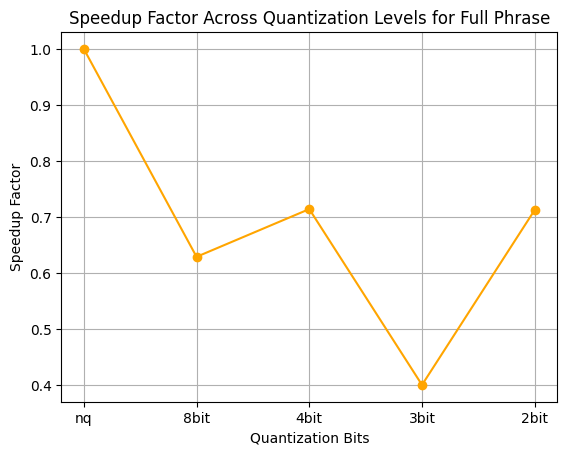

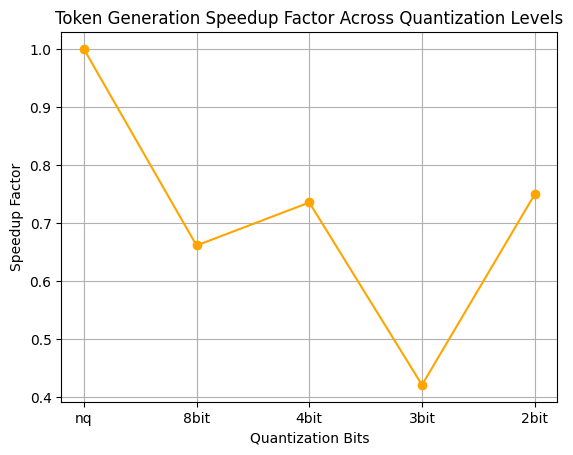

In [ ]:
configurations = ["nq", "8bit", "4bit", "3bit", "2bit"]
utils_QA.print_speedup(quantized_times, configurations)

### Test with 50 tokens generated

In [32]:
utils.set_seed(42)
list_files = os.listdir("SQuAD_models")
saving_dir = "QA_results\\results_50_tokens"
squad_evaluation_dataset = utils_QA.load_dataset("squad", split="validation")  # Use a small split for quick evaluation
seen = set()
unique_dataset = squad_dataset.filter(lambda example: example["question"] not in seen and not seen.add(example["question"]))
unique_dataset_10 = unique_dataset.select(range(10))
llama_path = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(llama_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
quantized_times = utils_QA.save_results_for_all_models(tokenizer, unique_dataset_10, llama_path, list_files, saving_dir, max_tokens = 50)

Tokenizer loaded!


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 2357.131MB
Base model loaded!
Computing results for base model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 750.693MB
Loaded quantized 2bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 867.600MB
Loaded quantized 3bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 984.506MB
Loaded quantized 4bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 1452.131MB
Loaded quantized 8bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


avg non quantized full phrase: 0.8410764500004007
avg non quantized token gen: 33.15603161530357
CONSIDERING MODEL QUANTIZED WITH 8bit bits
model average inference time: 2.4869 seconds per generation
Speedup for full phrase is : 0.34 times
model average token generation speed: 20.1061
Token Generation Speedup Factor: 0.61 times
CONSIDERING MODEL QUANTIZED WITH 4bit bits
model average inference time: 1.4076 seconds per generation
Speedup for full phrase is : 0.60 times
model average token generation speed: 20.0645
Token Generation Speedup Factor: 0.61 times
CONSIDERING MODEL QUANTIZED WITH 3bit bits
model average inference time: 4.7944 seconds per generation
Speedup for full phrase is : 0.18 times
model average token generation speed: 10.4721
Token Generation Speedup Factor: 0.32 times
CONSIDERING MODEL QUANTIZED WITH 2bit bits
model average inference time: 2.1348 seconds per generation
Speedup for full phrase is : 0.39 times
model average token generation speed: 23.8067
Token Generatio

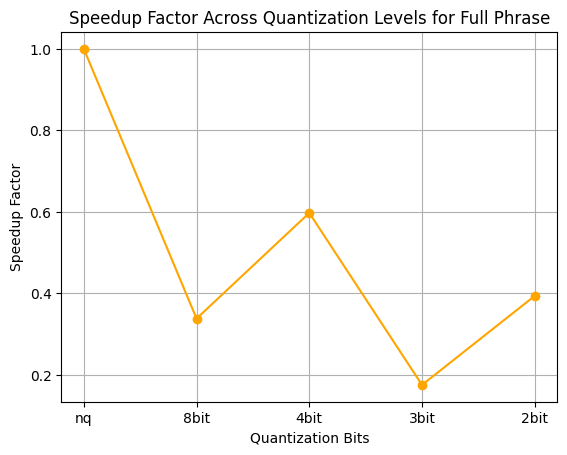

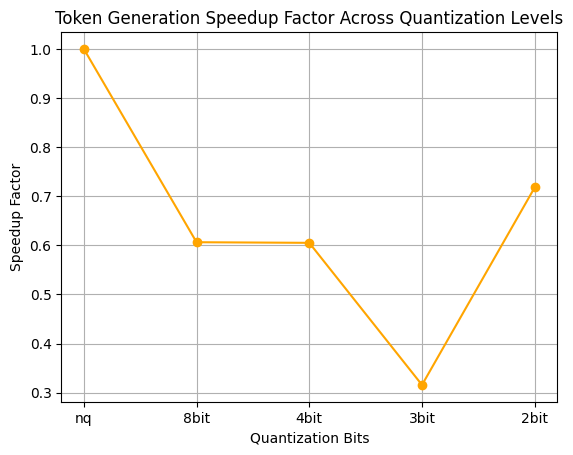

In [33]:
configurations = ["nq", "8bit", "4bit", "3bit", "2bit"]
utils_QA.print_speedup(quantized_times, configurations)

### Test with 150 tokens generated

In [28]:
utils.set_seed(42)
list_files = os.listdir("SQuAD_models")
saving_dir = "QA_results\\results_150_tokens"
squad_dataset = load_dataset("squad", split="validation")
filtered_dataset = squad_dataset.filter(lambda example: len(example["answers"]["text"][0].split()) > 20) #only lengthy answers
filtered_dataset_10 = filtered_dataset.select(range(10))
llama_path = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(llama_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
quantized_times = utils_QA.save_results_for_all_models(tokenizer, filtered_dataset_10, llama_path, list_files, saving_dir)

Tokenizer loaded!


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 2357.131MB
Base model loaded!
Computing results for base model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 750.693MB
Loaded quantized 2bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 867.600MB
Loaded quantized 3bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 984.506MB
Loaded quantized 4bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 1452.131MB
Loaded quantized 8bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


avg non quantized full phrase: 3.3303982200000517
avg non quantized token gen: 33.89370161070518
CONSIDERING MODEL QUANTIZED WITH 8bit bits
model average inference time: 5.7438 seconds per generation
Speedup for full phrase is : 0.58 times
model average token generation speed: 25.6527
Token Generation Speedup Factor: 0.76 times
CONSIDERING MODEL QUANTIZED WITH 4bit bits
model average inference time: 3.8774 seconds per generation
Speedup for full phrase is : 0.86 times
model average token generation speed: 27.3592
Token Generation Speedup Factor: 0.81 times
CONSIDERING MODEL QUANTIZED WITH 3bit bits
model average inference time: 8.6110 seconds per generation
Speedup for full phrase is : 0.39 times
model average token generation speed: 17.1248
Token Generation Speedup Factor: 0.51 times
CONSIDERING MODEL QUANTIZED WITH 2bit bits
model average inference time: 5.2451 seconds per generation
Speedup for full phrase is : 0.63 times
model average token generation speed: 28.0876
Token Generatio

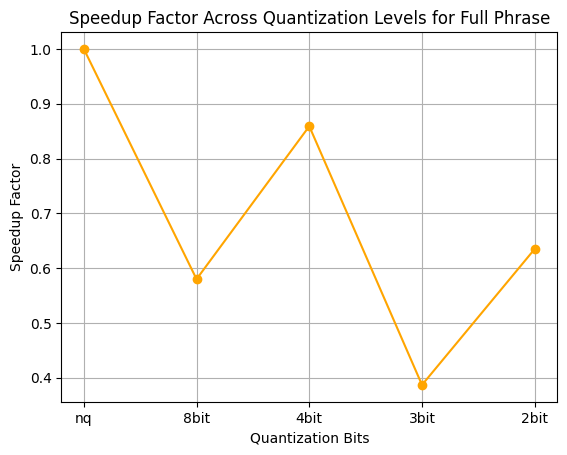

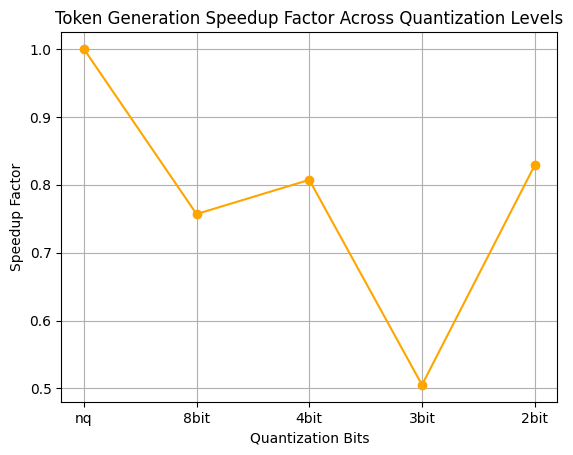

In [29]:
configurations = ["nq", "8bit", "4bit", "3bit", "2bit"]
utils_QA.print_speedup(quantized_times, configurations)

### Test with group size 64

In [47]:
importlib.reload(utils_QA)

utils.set_seed(42)
root_dir = "SQuAD_models\\group_size_64"
list_files = [os.path.join(root_dir, file) for file in os.listdir(root_dir)]
saving_dir = "QA_results\\group_size_64\\results_150_tokens"
squad_dataset = load_dataset("squad", split="validation")
filtered_dataset = squad_dataset.filter(lambda example: len(example["answers"]["text"][0].split()) > 20) #only lengthy answers
filtered_dataset_10 = filtered_dataset.select(range(10))
llama_path = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(llama_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
quantized_times = utils_QA.save_results_for_all_models(tokenizer, filtered_dataset_10, llama_path, list_files, saving_dir)

Tokenizer loaded!


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 2357.131MB
Base model loaded!
Computing results for base model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 767.006MB
Loaded quantized 2bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 884.818MB
Loaded quantized 3bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 1002.631MB
Loaded quantized 4bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


INFO - Compatibility: converting `checkpoint_format` from `gptq` to `gptq_v2`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


MODEL SIZE: 1473.881MB
Loaded quantized 8bit bit model
Computing results for quantized model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

...End!


avg non quantized full phrase: 3.3333109949991924
avg non quantized token gen: 34.28447112483903
CONSIDERING MODEL QUANTIZED WITH 8bit bits
model average inference time: 5.7853 seconds per generation
Speedup for full phrase is : 0.58 times
model average token generation speed: 25.9316
Token Generation Speedup Factor: 0.76 times
CONSIDERING MODEL QUANTIZED WITH 4bit bits
model average inference time: 4.2641 seconds per generation
Speedup for full phrase is : 0.78 times
model average token generation speed: 28.4394
Token Generation Speedup Factor: 0.83 times
CONSIDERING MODEL QUANTIZED WITH 3bit bits
model average inference time: 8.7667 seconds per generation
Speedup for full phrase is : 0.38 times
model average token generation speed: 17.1119
Token Generation Speedup Factor: 0.50 times
CONSIDERING MODEL QUANTIZED WITH 2bit bits
model average inference time: 5.2255 seconds per generation
Speedup for full phrase is : 0.64 times
model average token generation speed: 28.7099
Token Generatio

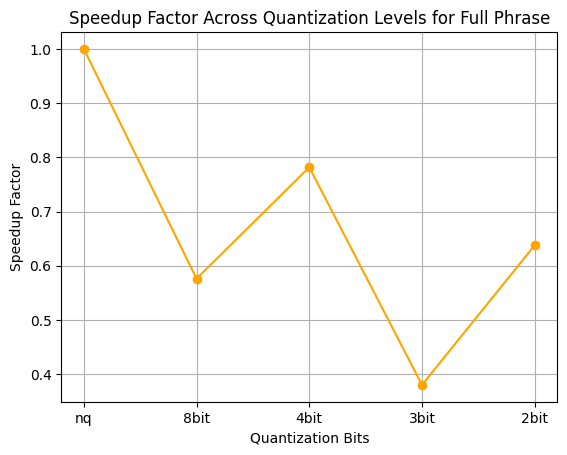

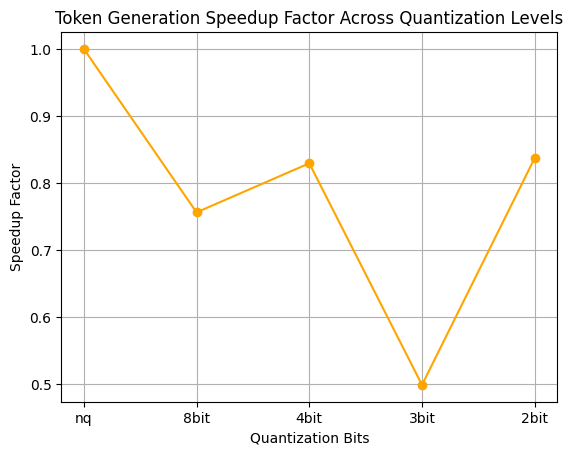

In [48]:
configurations = ["nq", "8bit", "4bit", "3bit", "2bit"]
utils_QA.print_speedup(quantized_times, configurations)

# Final thoughts about the experiment

#### **In terms of speed**:  
The experiment showed that the **non-quantized model is faster** at generating responses than the quantized ones, which contrasts with the expected outcome of quantization: a lighter (achieved) and faster (not achieved) model.

Each experiment was conducted **without parameters that might induce stochastic behavior (e.g., temperature)**. Additionally, each input was tested 5 different times to ensure a precise and robust computation of the elapsed time for each generation. Finally, **4 different experiments** were tested, with the model being able to generate **10, 50 and 150 token at most**, another one with 10 tokens and quantization with group size = 64, and the speedup was computed for both answer generation (which varies as each model might use a different number of tokens) and token generation speed.

With this in mind, this unexpected behavior could be explained by several factors:

- **I/O overhead for short sequences**: The **SQuAD dataset** has very short answers (none exceed 40 tokens). This means the average response length is relatively small if the model answers correctly. Quantization typically introduces some overhead to handle reduced precision, which may outweigh the speed gains for short sequences.
  
- **Batch size**: The batch size is set to 1 due to hardware constraints. A higher batch size could allow the model to fully leverage hardware optimizations and improve speed.
  
- **CUDA and GPU-specific behavior**: Since every operation relies on the GPU and CUDA backend, the observed behavior might be tied to GPU-specific constraints. It's possible (though unlikely) that the GPU used does not efficiently support lower-bit operations.
  
- **Aggressive quantization trade-offs**: Extremely aggressive quantization reduces the model's representational capacity, which may introduce additional computational challenges during inference.

Finally, the general trend for speed computation is as follows (from fastest to slowest):  
**non-quantized > 2-bit > 4-bit > 8-bit > 3-bit**  
It is noteworthy that the 3-bit implementation is the slowest. While this is surprising, it is likely due to its implementation not being as optimized as more commonly used quantization schemes.

#### **In terms of quality of generated text**:

- **2-bit quantization**: As expected, this level of quantization is far too aggressive. The text generated is essentially gibberish, consisting of random words and characters strung together. This network **always** utilizes the maximum number of tokens allowed, regardless of the input.

- **3-bit quantization**: This is a significant improvement over 2-bit quantization. It often produces correct answers but tends to include a lot of unnecessary information, sometimes even repeating the same answer or hallucinating additional content.  

- **4-bit quantization**: The performance here is very close to that of the non-quantized model. It produces answers that are mostly correct and comparable to the baseline. Occasionally, the model adds extraneous information that does not make sense. It achieves an F1-score of 0.67, slightly lower than the 0.69 of the non-quantized model.

- **8-bit quantization**: This was the most surprising result. The model consistently outputs a single word followed by many exclamation marks, suggesting a potential issue in the model's output layer or decoder. It is possible that the final layers are not receiving sufficient precision for accurate token prediction. Additionally, skewed output distributions during quantization might lead the model to predict high-probability tokens followed by nonsensical ones due to miscalculated logits.


### **Future Work**:

- **Hardware-Specific Optimization**: Investigating the behavior of quantized models on more advanced hardware, such as GPUs or TPUs explicitly optimized for low-bit operations could help determine if the current results are hardware-dependent.

- **Dynamic Quantization Schemes** (When implemented): Exploring adaptive quantization approaches, such as using higher precision (e.g., 8 bits) for the model’s final layers to ensure better token prediction while using lower precision (e.g., 2 bits) for earlier layers to reduce overhead.

- **Other Quantization Techniques or Implementations**: Other GPTQ implementation might be more optimized and work on every type of machine.

- **Fine-Tuning Post-Quantization**: Fine-tuning the quantized models on a subset of the SQuAD dataset or similar data to mitigate the loss of accuracy introduced by aggressive quantization.

### Dynamic quantization test (DOESN'T WORK, NO IMPLEMENTATION YET!)

In [8]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
quant_path = "Llama-3.2-1B-Instruct-gptqmodel-SQuAD-lowhigh-4bits-128gs"

tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the wikitext dataset

# Choose number of bits for quantization
quant_config = QuantizeConfig(bits=2, 
                              dynamic={"layer_0":{"bits": 4},
                                       "layer_1":{"bits": 4},
                                       "layer_2":{"bits": 4},
                                       "layer_13":{"bits": 4},
                                       "layer_14":{"bits": 4},
                                       "layer_15":{"bits": 4}},
                              group_size=128)

print("LOADING MODEL")
model = GPTQModel.load(model_id, quant_config)
print("MODEL LOADED")

print("QUANTIZING...")
model.quantize(used_dataset)

print("SAVING...")
model.save(quant_path)

LOADING MODEL


WARNING - GPTQModel's per-module `dynamic` quantization feature is currently not upstreamed to hf/vllm/sglang. If you're using vllm, you need to install this PR: https://github.com/vllm-project/vllm/pull/7086
INFO - Auto pick kernel based on compatibility: <class 'gptqmodel.nn_modules.qlinear.dynamic_cuda.DynamicCudaQuantLinear'>
WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 224.044.
WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


MODEL LOADED
QUANTIZING...
  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '5.56426', 'damp': '0.01000', 'time': '1.731', 'dynamic': None}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.14395', 'damp': '0.01000', 'time': '1.294', 'dynamic': None}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '11.66864', 'damp': '0.01000', 'time': '1.551', 'dynamic': None}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.01561', 'damp': '0.01000', 'time': '1.256', 'dynamic': None}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '10.48548', 'damp': '0.01000', 'time': '1.567', 'dynamic': None}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '13.23688', 'damp': '0.01000', 'time': '1.430', 'dynamic': None}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.08406', 'damp': '0.01000', 'time': '6.984', 'dynamic': None}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:02:44 / 0:21:52 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '11.40233', 'damp': '0.01000', 'time': '1.346', 'dynamic': None}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.63990', 'damp': '0.01000', 'time': '1.259', 'dynamic': None}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '21.60234', 'damp': '0.01000', 'time': '1.427', 'dynamic': None}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.03533', 'damp': '0.01000', 'time': '1.366', 'dynamic': None}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '17.62402', 'damp': '0.01000', 'time': '1.274', 'dynamic': None}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '24.20526', 'damp': '0.01000', 'time': '1.176', 'dynamic': None}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '154.98728', 'damp': '0.01000', 'time': '5.391', 'dynamic': None}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:05:24 / 0:28:48 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '16.65461', 'damp': '0.01000', 'time': '1.029', 'dynamic': None}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '1.19841', 'damp': '0.01000', 'time': '1.183', 'dynamic': None}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '33.34211', 'damp': '0.01000', 'time': '1.255', 'dynamic': None}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.03663', 'damp': '0.01000', 'time': '1.219', 'dynamic': None}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '19.41586', 'damp': '0.01000', 'time': '1.264', 'dynamic': None}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '31.13503', 'damp': '0.01000', 'time': '1.346', 'dynamic': None}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.21584', 'damp': '0.01000', 'time': '5.025', 'dynamic': None}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:08:01 / 0:32:04 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '13.93081', 'damp': '0.01000', 'time': '1.100', 'dynamic': None}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '1.82396', 'damp': '0.01000', 'time': '1.095', 'dynamic': None}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '30.61980', 'damp': '0.01000', 'time': '1.309', 'dynamic': None}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.06521', 'damp': '0.01000', 'time': '1.283', 'dynamic': None}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '26.11514', 'damp': '0.01000', 'time': '1.217', 'dynamic': None}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '51.98645', 'damp': '0.01000', 'time': '1.296', 'dynamic': None}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.33103', 'damp': '0.01000', 'time': '5.405', 'dynamic': None}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:10:40 / 0:34:08 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '16.60056', 'damp': '0.01000', 'time': '1.001', 'dynamic': None}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '1.95038', 'damp': '0.01000', 'time': '1.107', 'dynamic': None}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '34.68789', 'damp': '0.01000', 'time': '1.197', 'dynamic': None}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.11142', 'damp': '0.01000', 'time': '1.061', 'dynamic': None}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '29.35441', 'damp': '0.01000', 'time': '1.249', 'dynamic': None}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '63.11304', 'damp': '0.01000', 'time': '1.228', 'dynamic': None}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.41264', 'damp': '0.01000', 'time': '5.044', 'dynamic': None}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:13:15 / 0:35:20 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '25.26121', 'damp': '0.01000', 'time': '1.153', 'dynamic': None}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '1.81423', 'damp': '0.01000', 'time': '1.193', 'dynamic': None}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '45.81329', 'damp': '0.01000', 'time': '1.431', 'dynamic': None}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.12993', 'damp': '0.01000', 'time': '1.217', 'dynamic': None}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '32.44000', 'damp': '0.01000', 'time': '1.117', 'dynamic': None}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '59.74218', 'damp': '0.01000', 'time': '1.134', 'dynamic': None}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.48083', 'damp': '0.01000', 'time': '5.323', 'dynamic': None}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:15:52 / 0:36:16 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '23.58574', 'damp': '0.01000', 'time': '1.085', 'dynamic': None}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '2.48279', 'damp': '0.01000', 'time': '1.197', 'dynamic': None}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '36.92741', 'damp': '0.01000', 'time': '1.382', 'dynamic': None}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.20596', 'damp': '0.01000', 'time': '1.158', 'dynamic': None}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '33.41346', 'damp': '0.01000', 'time': '1.335', 'dynamic': None}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '60.15159', 'damp': '0.01000', 'time': '1.213', 'dynamic': None}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.52850', 'damp': '0.01000', 'time': '5.433', 'dynamic': None}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:18:29 / 0:36:58 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '24.65170', 'damp': '0.01000', 'time': '1.141', 'dynamic': None}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '3.00150', 'damp': '0.01000', 'time': '1.266', 'dynamic': None}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '45.88309', 'damp': '0.01000', 'time': '1.487', 'dynamic': None}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.20620', 'damp': '0.01000', 'time': '1.133', 'dynamic': None}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '36.42768', 'damp': '0.01000', 'time': '1.220', 'dynamic': None}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '58.85655', 'damp': '0.01000', 'time': '1.233', 'dynamic': None}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.60926', 'damp': '0.01000', 'time': '4.833', 'dynamic': None}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:21:05 / 0:37:28 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '29.72180', 'damp': '0.01000', 'time': '1.167', 'dynamic': None}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '2.99989', 'damp': '0.01000', 'time': '1.297', 'dynamic': None}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '48.68278', 'damp': '0.01000', 'time': '1.521', 'dynamic': None}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.25020', 'damp': '0.01000', 'time': '1.142', 'dynamic': None}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '41.37107', 'damp': '0.01000', 'time': '1.078', 'dynamic': None}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '64.75611', 'damp': '0.01000', 'time': '1.159', 'dynamic': None}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.78653', 'damp': '0.01000', 'time': '5.197', 'dynamic': None}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:23:43 / 0:37:56 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '24.44798', 'damp': '0.01000', 'time': '1.177', 'dynamic': None}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '3.56201', 'damp': '0.01000', 'time': '1.105', 'dynamic': None}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '59.40517', 'damp': '0.01000', 'time': '1.233', 'dynamic': None}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.43049', 'damp': '0.01000', 'time': '1.239', 'dynamic': None}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '45.98615', 'damp': '0.01000', 'time': '1.184', 'dynamic': None}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '74.61963', 'damp': '0.01000', 'time': '1.270', 'dynamic': None}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.95863', 'damp': '0.01000', 'time': '4.850', 'dynamic': None}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:26:21 / 0:38:19 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '29.21612', 'damp': '0.01000', 'time': '1.140', 'dynamic': None}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '3.60865', 'damp': '0.01000', 'time': '1.137', 'dynamic': None}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '60.90125', 'damp': '0.01000', 'time': '1.299', 'dynamic': None}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.37233', 'damp': '0.01000', 'time': '1.056', 'dynamic': None}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '55.77105', 'damp': '0.01000', 'time': '1.096', 'dynamic': None}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '87.55884', 'damp': '0.01000', 'time': '1.311', 'dynamic': None}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '1.30555', 'damp': '0.01000', 'time': '4.975', 'dynamic': None}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:28:58 / 0:38:37 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '35.37206', 'damp': '0.01000', 'time': '1.056', 'dynamic': None}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '3.79083', 'damp': '0.01000', 'time': '1.042', 'dynamic': None}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '60.34558', 'damp': '0.01000', 'time': '1.350', 'dynamic': None}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.26839', 'damp': '0.01000', 'time': '1.025', 'dynamic': None}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '65.23905', 'damp': '0.01000', 'time': '1.105', 'dynamic': None}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '100.09834', 'damp': '0.01000', 'time': '1.228', 'dynamic': None}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '1.66185', 'damp': '0.01000', 'time': '5.616', 'dynamic': None}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:31:34 / 0:38:51 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '34.21405', 'damp': '0.01000', 'time': '1.133', 'dynamic': None}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '3.95214', 'damp': '0.01000', 'time': '1.273', 'dynamic': None}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '62.12046', 'damp': '0.01000', 'time': '1.541', 'dynamic': None}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.29593', 'damp': '0.01000', 'time': '1.158', 'dynamic': None}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '71.77298', 'damp': '0.01000', 'time': '1.271', 'dynamic': None}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '104.32764', 'damp': '0.01000', 'time': '1.378', 'dynamic': None}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '2.17589', 'damp': '0.01000', 'time': '4.996', 'dynamic': None}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:34:11 / 0:39:04 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '34.58945', 'damp': '0.01000', 'time': '1.097', 'dynamic': None}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '6.37336', 'damp': '0.01000', 'time': '1.151', 'dynamic': None}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '68.96320', 'damp': '0.01000', 'time': '1.325', 'dynamic': None}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.48532', 'damp': '0.01000', 'time': '1.130', 'dynamic': None}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '84.16047', 'damp': '0.01000', 'time': '1.188', 'dynamic': None}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '111.79678', 'damp': '0.01000', 'time': '1.219', 'dynamic': None}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '3.22090', 'damp': '0.01000', 'time': '4.925', 'dynamic': None}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:36:46 / 0:39:13 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '33.10991', 'damp': '0.01000', 'time': '1.083', 'dynamic': None}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '12.61296', 'damp': '0.01000', 'time': '1.149', 'dynamic': None}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '67.77684', 'damp': '0.01000', 'time': '1.213', 'dynamic': None}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '1.24972', 'damp': '0.01000', 'time': '1.055', 'dynamic': None}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '94.26672', 'damp': '0.01000', 'time': '1.250', 'dynamic': None}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '135.25284', 'damp': '0.01000', 'time': '1.300', 'dynamic': None}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '3.99224', 'damp': '0.01000', 'time': '4.967', 'dynamic': None}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:39:24 / 0:39:24 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '30.56205', 'damp': '0.01000', 'time': '1.020', 'dynamic': None}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '13.48467', 'damp': '0.01000', 'time': '1.238', 'dynamic': None}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '62.45148', 'damp': '0.01000', 'time': '1.327', 'dynamic': None}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '3.32128', 'damp': '0.01000', 'time': '1.093', 'dynamic': None}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '117.93300', 'damp': '0.01000', 'time': '1.149', 'dynamic': None}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '156.44528', 'damp': '0.01000', 'time': '1.449', 'dynamic': None}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '9.80284', 'damp': '0.01000', 'time': '5.483', 'dynamic': None}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '5.56426', 'damp': '0.01000', 'time': '1.731', 'dynamic': None

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%7 / 1:27:44 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING...


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1251.74MB, 1.22GB
INFO - Size difference: 3462.58MB, 3.38GB - 73.45%


In [9]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
quant_path = "Llama-3.2-1B-Instruct-gptqmodel-SQuAD-lowhigh-2bits-128gs"

tokenizer = AutoTokenizer.from_pretrained(model_id)

# Choose number of bits for quantization
quant_config = QuantizeConfig(bits=4, 
                              dynamic={"layer_0":{"bits": 2},
                                       "layer_1":{"bits": 2},
                                       "layer_2":{"bits": 2},
                                       "layer_13":{"bits": 2},
                                       "layer_14":{"bits": 2},
                                       "layer_15":{"bits": 2}},
                              group_size=128)

print("LOADING MODEL")
model = GPTQModel.load(model_id, quant_config)
print("MODEL LOADED")

print("QUANTIZING...")
model.quantize(used_dataset)

print("SAVING...")
model.save(quant_path)

LOADING MODEL


WARNING - GPTQModel's per-module `dynamic` quantization feature is currently not upstreamed to hf/vllm/sglang. If you're using vllm, you need to install this PR: https://github.com/vllm-project/vllm/pull/7086
WARNING - The average length of input_ids of calibration_dataset should be greater than 256: actual avg: 224.044.
WARNING - Model config does not have pad token mapped. Please pass in tokenizer to `quantize()` so GPTQModel can auto-select the best pad token.


MODEL LOADED
QUANTIZING...
  |██--------------------------------------| 0:00:00 / 0:00:00 [1/16] 6.2%

INFO - {'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.14485', 'damp': '0.01000', 'time': '1.114', 'dynamic': None}
INFO - {'layer': 0, 'module': 'self_attn.v_proj', 'loss': '0.00446', 'damp': '0.01000', 'time': '1.240', 'dynamic': None}
INFO - {'layer': 0, 'module': 'self_attn.q_proj', 'loss': '0.30720', 'damp': '0.01000', 'time': '1.411', 'dynamic': None}
INFO - {'layer': 0, 'module': 'self_attn.o_proj', 'loss': '0.00049', 'damp': '0.01000', 'time': '1.160', 'dynamic': None}
INFO - {'layer': 0, 'module': 'mlp.up_proj', 'loss': '0.32733', 'damp': '0.01000', 'time': '1.196', 'dynamic': None}
INFO - {'layer': 0, 'module': 'mlp.gate_proj', 'loss': '0.40889', 'damp': '0.01000', 'time': '1.250', 'dynamic': None}
INFO - {'layer': 0, 'module': 'mlp.down_proj', 'loss': '0.00189', 'damp': '0.01000', 'time': '4.932', 'dynamic': None}


 Quantizing mlp.down_proj in layer 0 of 15 |█████-----------------------------------| 0:02:36 / 0:20:48 [2/16] 12.5%

INFO - {'layer': 1, 'module': 'self_attn.k_proj', 'loss': '0.29541', 'damp': '0.01000', 'time': '1.200', 'dynamic': None}
INFO - {'layer': 1, 'module': 'self_attn.v_proj', 'loss': '0.01786', 'damp': '0.01000', 'time': '1.193', 'dynamic': None}
INFO - {'layer': 1, 'module': 'self_attn.q_proj', 'loss': '0.59259', 'damp': '0.01000', 'time': '1.304', 'dynamic': None}
INFO - {'layer': 1, 'module': 'self_attn.o_proj', 'loss': '0.00106', 'damp': '0.01000', 'time': '1.158', 'dynamic': None}
INFO - {'layer': 1, 'module': 'mlp.up_proj', 'loss': '0.51571', 'damp': '0.01000', 'time': '1.226', 'dynamic': None}
INFO - {'layer': 1, 'module': 'mlp.gate_proj', 'loss': '0.70487', 'damp': '0.01000', 'time': '1.260', 'dynamic': None}
INFO - {'layer': 1, 'module': 'mlp.down_proj', 'loss': '3.92007', 'damp': '0.01000', 'time': '5.779', 'dynamic': None}


 Quantizing mlp.down_proj in layer 1 of 15 |███████---------------------------------| 0:05:15 / 0:28:00 [3/16] 18.8%

INFO - {'layer': 2, 'module': 'self_attn.k_proj', 'loss': '0.60806', 'damp': '0.01000', 'time': '1.043', 'dynamic': None}
INFO - {'layer': 2, 'module': 'self_attn.v_proj', 'loss': '0.04492', 'damp': '0.01000', 'time': '1.121', 'dynamic': None}
INFO - {'layer': 2, 'module': 'self_attn.q_proj', 'loss': '1.18702', 'damp': '0.01000', 'time': '1.265', 'dynamic': None}
INFO - {'layer': 2, 'module': 'self_attn.o_proj', 'loss': '0.00115', 'damp': '0.01000', 'time': '1.067', 'dynamic': None}
INFO - {'layer': 2, 'module': 'mlp.up_proj', 'loss': '0.69052', 'damp': '0.01000', 'time': '1.112', 'dynamic': None}
INFO - {'layer': 2, 'module': 'mlp.gate_proj', 'loss': '1.08845', 'damp': '0.01000', 'time': '1.169', 'dynamic': None}
INFO - {'layer': 2, 'module': 'mlp.down_proj', 'loss': '0.00556', 'damp': '0.01000', 'time': '5.455', 'dynamic': None}


 Quantizing mlp.down_proj in layer 2 of 15 |██████████------------------------------| 0:07:52 / 0:31:28 [4/16] 25.0%

INFO - {'layer': 3, 'module': 'self_attn.k_proj', 'loss': '0.42209', 'damp': '0.01000', 'time': '1.057', 'dynamic': None}
INFO - {'layer': 3, 'module': 'self_attn.v_proj', 'loss': '0.05926', 'damp': '0.01000', 'time': '1.140', 'dynamic': None}
INFO - {'layer': 3, 'module': 'self_attn.q_proj', 'loss': '0.93165', 'damp': '0.01000', 'time': '1.142', 'dynamic': None}
INFO - {'layer': 3, 'module': 'self_attn.o_proj', 'loss': '0.00249', 'damp': '0.01000', 'time': '1.095', 'dynamic': None}
INFO - {'layer': 3, 'module': 'mlp.up_proj', 'loss': '0.82591', 'damp': '0.01000', 'time': '1.183', 'dynamic': None}
INFO - {'layer': 3, 'module': 'mlp.gate_proj', 'loss': '1.62938', 'damp': '0.01000', 'time': '1.236', 'dynamic': None}
INFO - {'layer': 3, 'module': 'mlp.down_proj', 'loss': '0.00870', 'damp': '0.01000', 'time': '5.182', 'dynamic': None}


 Quantizing mlp.down_proj in layer 3 of 15 |████████████----------------------------| 0:10:29 / 0:33:32 [5/16] 31.2%

INFO - {'layer': 4, 'module': 'self_attn.k_proj', 'loss': '0.43019', 'damp': '0.01000', 'time': '1.050', 'dynamic': None}
INFO - {'layer': 4, 'module': 'self_attn.v_proj', 'loss': '0.05364', 'damp': '0.01000', 'time': '1.140', 'dynamic': None}
INFO - {'layer': 4, 'module': 'self_attn.q_proj', 'loss': '0.89892', 'damp': '0.01000', 'time': '1.162', 'dynamic': None}
INFO - {'layer': 4, 'module': 'self_attn.o_proj', 'loss': '0.00447', 'damp': '0.01000', 'time': '1.052', 'dynamic': None}
INFO - {'layer': 4, 'module': 'mlp.up_proj', 'loss': '0.81918', 'damp': '0.01000', 'time': '1.144', 'dynamic': None}
INFO - {'layer': 4, 'module': 'mlp.gate_proj', 'loss': '1.74790', 'damp': '0.01000', 'time': '1.142', 'dynamic': None}
INFO - {'layer': 4, 'module': 'mlp.down_proj', 'loss': '0.01037', 'damp': '0.01000', 'time': '5.116', 'dynamic': None}


 Quantizing mlp.down_proj in layer 4 of 15 |███████████████-------------------------| 0:13:03 / 0:34:48 [6/16] 37.5%

INFO - {'layer': 5, 'module': 'self_attn.k_proj', 'loss': '0.63729', 'damp': '0.01000', 'time': '1.233', 'dynamic': None}
INFO - {'layer': 5, 'module': 'self_attn.v_proj', 'loss': '0.04552', 'damp': '0.01000', 'time': '1.168', 'dynamic': None}
INFO - {'layer': 5, 'module': 'self_attn.q_proj', 'loss': '1.12357', 'damp': '0.01000', 'time': '1.283', 'dynamic': None}
INFO - {'layer': 5, 'module': 'self_attn.o_proj', 'loss': '0.00474', 'damp': '0.01000', 'time': '1.108', 'dynamic': None}
INFO - {'layer': 5, 'module': 'mlp.up_proj', 'loss': '0.85132', 'damp': '0.01000', 'time': '1.249', 'dynamic': None}
INFO - {'layer': 5, 'module': 'mlp.gate_proj', 'loss': '1.55171', 'damp': '0.01000', 'time': '1.162', 'dynamic': None}
INFO - {'layer': 5, 'module': 'mlp.down_proj', 'loss': '0.01213', 'damp': '0.01000', 'time': '5.949', 'dynamic': None}


 Quantizing mlp.down_proj in layer 5 of 15 |█████████████████-----------------------| 0:15:42 / 0:35:53 [7/16] 43.8%

INFO - {'layer': 6, 'module': 'self_attn.k_proj', 'loss': '0.51553', 'damp': '0.01000', 'time': '1.044', 'dynamic': None}
INFO - {'layer': 6, 'module': 'self_attn.v_proj', 'loss': '0.05870', 'damp': '0.01000', 'time': '1.207', 'dynamic': None}
INFO - {'layer': 6, 'module': 'self_attn.q_proj', 'loss': '0.83380', 'damp': '0.01000', 'time': '1.358', 'dynamic': None}
INFO - {'layer': 6, 'module': 'self_attn.o_proj', 'loss': '0.00716', 'damp': '0.01000', 'time': '1.208', 'dynamic': None}
INFO - {'layer': 6, 'module': 'mlp.up_proj', 'loss': '0.85103', 'damp': '0.01000', 'time': '1.208', 'dynamic': None}
INFO - {'layer': 6, 'module': 'mlp.gate_proj', 'loss': '1.51679', 'damp': '0.01000', 'time': '1.346', 'dynamic': None}
INFO - {'layer': 6, 'module': 'mlp.down_proj', 'loss': '0.01262', 'damp': '0.01000', 'time': '5.434', 'dynamic': None}


 Quantizing mlp.down_proj in layer 6 of 15 |████████████████████--------------------| 0:18:21 / 0:36:42 [8/16] 50.0%

INFO - {'layer': 7, 'module': 'self_attn.k_proj', 'loss': '0.50693', 'damp': '0.01000', 'time': '1.092', 'dynamic': None}
INFO - {'layer': 7, 'module': 'self_attn.v_proj', 'loss': '0.06601', 'damp': '0.01000', 'time': '1.236', 'dynamic': None}
INFO - {'layer': 7, 'module': 'self_attn.q_proj', 'loss': '0.97188', 'damp': '0.01000', 'time': '1.273', 'dynamic': None}
INFO - {'layer': 7, 'module': 'self_attn.o_proj', 'loss': '0.00689', 'damp': '0.01000', 'time': '1.149', 'dynamic': None}
INFO - {'layer': 7, 'module': 'mlp.up_proj', 'loss': '0.86535', 'damp': '0.01000', 'time': '1.175', 'dynamic': None}
INFO - {'layer': 7, 'module': 'mlp.gate_proj', 'loss': '1.39177', 'damp': '0.01000', 'time': '1.267', 'dynamic': None}
INFO - {'layer': 7, 'module': 'mlp.down_proj', 'loss': '0.01390', 'damp': '0.01000', 'time': '5.607', 'dynamic': None}


 Quantizing mlp.down_proj in layer 7 of 15 |██████████████████████------------------| 0:20:56 / 0:37:12 [9/16] 56.2%

INFO - {'layer': 8, 'module': 'self_attn.k_proj', 'loss': '0.59795', 'damp': '0.01000', 'time': '1.025', 'dynamic': None}
INFO - {'layer': 8, 'module': 'self_attn.v_proj', 'loss': '0.06280', 'damp': '0.01000', 'time': '1.142', 'dynamic': None}
INFO - {'layer': 8, 'module': 'self_attn.q_proj', 'loss': '1.00068', 'damp': '0.01000', 'time': '1.204', 'dynamic': None}
INFO - {'layer': 8, 'module': 'self_attn.o_proj', 'loss': '0.00875', 'damp': '0.01000', 'time': '1.208', 'dynamic': None}
INFO - {'layer': 8, 'module': 'mlp.up_proj', 'loss': '0.94350', 'damp': '0.01000', 'time': '1.236', 'dynamic': None}
INFO - {'layer': 8, 'module': 'mlp.gate_proj', 'loss': '1.47327', 'damp': '0.01000', 'time': '1.366', 'dynamic': None}
INFO - {'layer': 8, 'module': 'mlp.down_proj', 'loss': '0.01813', 'damp': '0.01000', 'time': '5.616', 'dynamic': None}


 Quantizing mlp.down_proj in layer 8 of 15 |█████████████████████████---------------| 0:23:32 / 0:37:39 [10/16] 62.5%

INFO - {'layer': 9, 'module': 'self_attn.k_proj', 'loss': '0.47748', 'damp': '0.01000', 'time': '1.108', 'dynamic': None}
INFO - {'layer': 9, 'module': 'self_attn.v_proj', 'loss': '0.07387', 'damp': '0.01000', 'time': '1.269', 'dynamic': None}
INFO - {'layer': 9, 'module': 'self_attn.q_proj', 'loss': '1.17901', 'damp': '0.01000', 'time': '1.424', 'dynamic': None}
INFO - {'layer': 9, 'module': 'self_attn.o_proj', 'loss': '0.01174', 'damp': '0.01000', 'time': '1.078', 'dynamic': None}
INFO - {'layer': 9, 'module': 'mlp.up_proj', 'loss': '0.97912', 'damp': '0.01000', 'time': '1.183', 'dynamic': None}
INFO - {'layer': 9, 'module': 'mlp.gate_proj', 'loss': '1.57666', 'damp': '0.01000', 'time': '1.262', 'dynamic': None}
INFO - {'layer': 9, 'module': 'mlp.down_proj', 'loss': '0.02105', 'damp': '0.01000', 'time': '5.154', 'dynamic': None}


 Quantizing mlp.down_proj in layer 9 of 15 |███████████████████████████-------------| 0:26:08 / 0:38:00 [11/16] 68.8%

INFO - {'layer': 10, 'module': 'self_attn.k_proj', 'loss': '0.54732', 'damp': '0.01000', 'time': '1.116', 'dynamic': None}
INFO - {'layer': 10, 'module': 'self_attn.v_proj', 'loss': '0.07788', 'damp': '0.01000', 'time': '1.149', 'dynamic': None}
INFO - {'layer': 10, 'module': 'self_attn.q_proj', 'loss': '1.17159', 'damp': '0.01000', 'time': '1.549', 'dynamic': None}
INFO - {'layer': 10, 'module': 'self_attn.o_proj', 'loss': '0.00765', 'damp': '0.01000', 'time': '1.218', 'dynamic': None}
INFO - {'layer': 10, 'module': 'mlp.up_proj', 'loss': '1.14234', 'damp': '0.01000', 'time': '1.253', 'dynamic': None}
INFO - {'layer': 10, 'module': 'mlp.gate_proj', 'loss': '1.77713', 'damp': '0.01000', 'time': '1.410', 'dynamic': None}
INFO - {'layer': 10, 'module': 'mlp.down_proj', 'loss': '0.02611', 'damp': '0.01000', 'time': '5.557', 'dynamic': None}


 Quantizing mlp.down_proj in layer 10 of 15 |██████████████████████████████----------| 0:28:45 / 0:38:20 [12/16] 75.0%

INFO - {'layer': 11, 'module': 'self_attn.k_proj', 'loss': '0.65959', 'damp': '0.01000', 'time': '1.000', 'dynamic': None}
INFO - {'layer': 11, 'module': 'self_attn.v_proj', 'loss': '0.08198', 'damp': '0.01000', 'time': '1.244', 'dynamic': None}
INFO - {'layer': 11, 'module': 'self_attn.q_proj', 'loss': '1.17407', 'damp': '0.01000', 'time': '1.288', 'dynamic': None}
INFO - {'layer': 11, 'module': 'self_attn.o_proj', 'loss': '0.00665', 'damp': '0.01000', 'time': '1.065', 'dynamic': None}
INFO - {'layer': 11, 'module': 'mlp.up_proj', 'loss': '1.31149', 'damp': '0.01000', 'time': '1.121', 'dynamic': None}
INFO - {'layer': 11, 'module': 'mlp.gate_proj', 'loss': '2.00358', 'damp': '0.01000', 'time': '1.200', 'dynamic': None}
INFO - {'layer': 11, 'module': 'mlp.down_proj', 'loss': '0.02946', 'damp': '0.01000', 'time': '5.279', 'dynamic': None}


 Quantizing mlp.down_proj in layer 11 of 15 |████████████████████████████████--------| 0:31:22 / 0:38:36 [13/16] 81.2%

INFO - {'layer': 12, 'module': 'self_attn.k_proj', 'loss': '0.66540', 'damp': '0.01000', 'time': '1.175', 'dynamic': None}
INFO - {'layer': 12, 'module': 'self_attn.v_proj', 'loss': '0.08446', 'damp': '0.01000', 'time': '1.165', 'dynamic': None}
INFO - {'layer': 12, 'module': 'self_attn.q_proj', 'loss': '1.17945', 'damp': '0.01000', 'time': '1.358', 'dynamic': None}
INFO - {'layer': 12, 'module': 'self_attn.o_proj', 'loss': '0.00593', 'damp': '0.01000', 'time': '1.139', 'dynamic': None}
INFO - {'layer': 12, 'module': 'mlp.up_proj', 'loss': '1.41761', 'damp': '0.01000', 'time': '1.196', 'dynamic': None}
INFO - {'layer': 12, 'module': 'mlp.gate_proj', 'loss': '2.05939', 'damp': '0.01000', 'time': '1.241', 'dynamic': None}
INFO - {'layer': 12, 'module': 'mlp.down_proj', 'loss': '0.03522', 'damp': '0.01000', 'time': '5.525', 'dynamic': None}


 Quantizing mlp.down_proj in layer 12 of 15 |███████████████████████████████████-----| 0:34:00 / 0:38:51 [14/16] 87.5%

INFO - {'layer': 13, 'module': 'self_attn.k_proj', 'loss': '0.67996', 'damp': '0.01000', 'time': '1.155', 'dynamic': None}
INFO - {'layer': 13, 'module': 'self_attn.v_proj', 'loss': '0.14611', 'damp': '0.01000', 'time': '1.147', 'dynamic': None}
INFO - {'layer': 13, 'module': 'self_attn.q_proj', 'loss': '1.38109', 'damp': '0.01000', 'time': '1.294', 'dynamic': None}
INFO - {'layer': 13, 'module': 'self_attn.o_proj', 'loss': '0.00689', 'damp': '0.01000', 'time': '1.134', 'dynamic': None}
INFO - {'layer': 13, 'module': 'mlp.up_proj', 'loss': '1.70011', 'damp': '0.01000', 'time': '1.265', 'dynamic': None}
INFO - {'layer': 13, 'module': 'mlp.gate_proj', 'loss': '2.25610', 'damp': '0.01000', 'time': '1.318', 'dynamic': None}
INFO - {'layer': 13, 'module': 'mlp.down_proj', 'loss': '0.05104', 'damp': '0.01000', 'time': '4.962', 'dynamic': None}


 Quantizing mlp.down_proj in layer 13 of 15 |█████████████████████████████████████---| 0:36:34 / 0:39:00 [15/16] 93.8%

INFO - {'layer': 14, 'module': 'self_attn.k_proj', 'loss': '0.75266', 'damp': '0.01000', 'time': '1.095', 'dynamic': None}
INFO - {'layer': 14, 'module': 'self_attn.v_proj', 'loss': '0.31072', 'damp': '0.01000', 'time': '1.188', 'dynamic': None}
INFO - {'layer': 14, 'module': 'self_attn.q_proj', 'loss': '1.44708', 'damp': '0.01000', 'time': '1.486', 'dynamic': None}
INFO - {'layer': 14, 'module': 'self_attn.o_proj', 'loss': '0.01597', 'damp': '0.01000', 'time': '1.094', 'dynamic': None}
INFO - {'layer': 14, 'module': 'mlp.up_proj', 'loss': '1.96066', 'damp': '0.01000', 'time': '1.176', 'dynamic': None}
INFO - {'layer': 14, 'module': 'mlp.gate_proj', 'loss': '2.81593', 'damp': '0.01000', 'time': '1.206', 'dynamic': None}
INFO - {'layer': 14, 'module': 'mlp.down_proj', 'loss': '0.06885', 'damp': '0.01000', 'time': '4.867', 'dynamic': None}


 Quantizing mlp.down_proj in layer 14 of 15 |████████████████████████████████████████| 0:39:11 / 0:39:11 [16/16] 100.0%

INFO - {'layer': 15, 'module': 'self_attn.k_proj', 'loss': '0.73069', 'damp': '0.01000', 'time': '1.062', 'dynamic': None}
INFO - {'layer': 15, 'module': 'self_attn.v_proj', 'loss': '0.31368', 'damp': '0.01000', 'time': '1.135', 'dynamic': None}
INFO - {'layer': 15, 'module': 'self_attn.q_proj', 'loss': '1.33757', 'damp': '0.01000', 'time': '1.174', 'dynamic': None}
INFO - {'layer': 15, 'module': 'self_attn.o_proj', 'loss': '0.09811', 'damp': '0.01000', 'time': '1.200', 'dynamic': None}
INFO - {'layer': 15, 'module': 'mlp.up_proj', 'loss': '2.45545', 'damp': '0.01000', 'time': '1.285', 'dynamic': None}
INFO - {'layer': 15, 'module': 'mlp.gate_proj', 'loss': '3.25411', 'damp': '0.01000', 'time': '1.379', 'dynamic': None}
INFO - {'layer': 15, 'module': 'mlp.down_proj', 'loss': '0.20160', 'damp': '0.01000', 'time': '4.882', 'dynamic': None}
INFO - Quantization summary:
[{'layer': 0, 'module': 'self_attn.k_proj', 'loss': '0.14485', 'damp': '0.01000', 'time': '1.114', 'dynamic': None}, {'la

 Packing model.layers.15.mlp.down_proj |----------------------------------------| 100.0%0 / 1:33:20 [0/112] 0.0%.0%

INFO - Model packed.


 Quantizing mlp.down_proj in layer 15 of 15 |----------------------------------------| 100.0%SAVING...


INFO - Pre-Quantized model size: 4714.32MB, 4.60GB
INFO - Quantized model size: 1485.55MB, 1.45GB
INFO - Size difference: 3228.77MB, 3.15GB - 68.49%
